# Railway Delay Classification — Binary Prediction Pipeline

**Project Goal:** Predict whether a train will experience significant delay (>15 minutes) to enable proactive operations, resource allocation, and passenger communication.

**Approach:** This notebook implements a complete binary classification pipeline covering:
1. Introduction & Problem Definition
2. Data Description & Quality Assessment
3. Data Preprocessing
4. Exploratory Data Analysis (EDA)
5. Feature Engineering & Metrics Definition
6. Model Training & Evaluation
7. Comparison & Deployment Recommendations

**Dataset:** Railway delay records with temporal, operational, and delay-cause features.

---

# 1. Introduction

## Background & Business Problem

Railway delays cause **cascading operational failures**, passenger dissatisfaction, missed connections, and financial losses. When predictions are wrong:
- **False Negatives (missed delays):** No proactive mitigation → resource unavailability, passenger frustration, compensation costs
- **False Positives (false alarms):** Unnecessary resource deployment → wasted costs, operational inefficiency

**Impact:**
- Operational cost per unmanaged delay: ≈ $500-2,000 (crew overtime, refunds, rebooking)
- Customer churn risk: 15-25% after 2+ poor experiences
- Network congestion: one 30-min delay can cascade to 10+ trains

## Motivation

A **binary classification model** enables:
1. **Cost Optimization:** Prioritize resource allocation to high-risk trains
2. **Recall Improvement:** Catch most delays (even at cost of some false alarms)
3. **Risk Reduction:** Proactive communication and contingency planning
4. **Operational Efficiency:** Schedule adjustments, crew reallocation

## Project Objectives

### Target Variable Definition
- **Target (`y`):** `SIGNIFICANT_DELAY` = 1 if `DELAY_ARRIVAL > 15 minutes`, else 0
  - **y=1:** Train will arrive >15 min late (requires intervention)
  - **y=0:** Train on-time or minor delay (<15 min)

### Prediction Unit
- **One prediction per scheduled train journey** (unique by `TRAIN_NUMBER`, `DATE`, `SOURCE_STATION`, `DESTINATION_STATION`)

### Success Criteria
1. **Primary Metric:** **F2-score ≥ 0.70** (prioritizes Recall over Precision)
   - Rationale: Catching delays (high Recall) is more critical than avoiding false alarms
2. **Secondary Metrics:**
   - **Recall ≥ 0.80** at **Precision ≥ 0.60** (80% of delays caught, 60% alerts are real)
   - **PR-AUC ≥ 0.75** (strong discrimination in imbalanced setting)
   - **ROC-AUC ≥ 0.85** (overall classification quality)

### Constraints
- **Latency:** Predictions needed **1-2 hours before scheduled departure** → lightweight models preferred
- **Interpretability:** Operations team needs **explainable predictions** → SHAP values, feature importance
- **Temporal Data:** Training uses **historical data only** (strict time-based splitting)
- **Leakage Risks:**
  - Exclude `ACTUAL_ARRIVAL`, `DELAY_ARRIVAL` (computed post-event)
  - Use only scheduled times, historical patterns, weather forecasts

---

## Model Families (High-Level)

### Baseline
- **Logistic Regression** (L1/L2 regularized, `class_weight='balanced'`)

### Primary Models
- **Random Forest** (handles non-linearity, robust to missing data)
- **Gradient Boosting:**
  - **XGBoost** (fast, effective for structured data)
  - **LightGBM** (efficient for large datasets)
  - **CatBoost** (native categorical handling)

### Optional (for comparison)
- SVM (RBF kernel, scaled features)
- KNN (distance-based baseline)
- Naive Bayes (fast probabilistic baseline)

### Imbalance Handling
- **Class weights** (penalize misclassifying minority class)
- **Threshold tuning** (optimize for F2 instead of default 0.5)
- *Optional:* SMOTE/undersampling (if class weights insufficient)

---

## Metrics Defined Upfront

| Metric | Purpose | Target |
|--------|---------|--------|
| **F2-score** | Emphasize Recall (catch delays) | ≥ 0.70 |
| **Recall** | % of actual delays caught | ≥ 0.80 |
| **Precision** | % of alerts that are real delays | ≥ 0.60 |
| **PR-AUC** | Discrimination under imbalance | ≥ 0.75 |
| **ROC-AUC** | Overall classification quality | ≥ 0.85 |
| **Balanced Accuracy** | Account for class imbalance | ≥ 0.75 |
| **Brier Score** | Calibration (if using probabilities) | < 0.15 |

---

## Pipeline Diagram

```
┌─────────────┐
│   RAW DATA  │ (31 features, temporal + operational)
└──────┬──────┘
       │
       ▼
┌─────────────────────────┐
│   PREPROCESSING         │
│ • Handle missing values │
│ • Encode categoricals   │
│ • Create datetime feats │
│ • Scale numeric         │
└──────────┬──────────────┘
           │
           ▼
┌─────────────────────────┐
│   FEATURE ENGINEERING   │
│ • Lag features          │
│ • Rolling stats         │
│ • Interactions          │
│ • Missingness flags     │
└──────────┬──────────────┘
           │
           ▼
┌─────────────────────────┐
│   MODEL TRAINING        │
│ • Baseline (Logistic)   │
│ • Tree Ensembles        │
│ • Time-based CV         │
│ • Hyperparameter tuning │
└──────────┬──────────────┘
           │
           ▼
┌─────────────────────────┐
│   EVALUATION            │
│ • F2, Recall, Precision │
│ • ROC/PR curves         │
│ • SHAP values           │
│ • Threshold optimization│
└──────────┬──────────────┘
           │
           ▼
┌─────────────────────────┐
│   DEPLOYMENT            │
│ • Persist pipeline      │
│ • Monitor drift         │
│ • Retrain on schedule   │
└─────────────────────────┘
```

---

## Cost Matrix (FP/FN Impact)

| Actual \ Predicted | **Predict: No Delay (0)** | **Predict: Delay (1)** |
|--------------------:|:-------------------------:|:----------------------:|
| **Actual: No Delay (0)** | ✓ True Negative (TN) | ✗ False Positive (FP)<br>Cost: ~$100<br>(Unnecessary resource allocation) |
| **Actual: Delay (1)** | ✗✗ **False Negative (FN)**<br>**Cost: ~$1,500**<br>(Missed delay → passenger complaints, compensation, cascading failures) | ✓ True Positive (TP)<br>Benefit: ~$1,000<br>(Proactive mitigation) |

**Key Insight:** FN cost ≈ 15× FP cost → **prioritize Recall** (minimize FN) → **F2-score** as primary metric.

# 2. Data Description

## Overview

This section provides a comprehensive understanding of the dataset structure, quality, and potential issues before modeling.

### Dataset Source
- **Origin:** Railway operational logs (2015-2023)
- **Granularity:** One record per scheduled train journey
- **Files:**
  - `merged_train_data.csv` (primary training data)
  - `railway-delay-dataset.csv` (holdout test)

In [1]:
# Section 2: Data Description - Load and Analyze

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
DATA_PATH = r"D:\AnDB\L\mse\railway-delay\docs\merged_train_data.csv"
df = pd.read_csv(DATA_PATH)

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nDuplicate records: {df.duplicated().sum():,}")

# Create binary target
DELAY_THRESHOLD = 15  # minutes
df['DELAY_ARRIVAL'] = pd.to_numeric(df['DELAY_ARRIVAL'], errors='coerce')
df['SIGNIFICANT_DELAY'] = (df['DELAY_ARRIVAL'] > DELAY_THRESHOLD).astype(int)

# Class distribution
class_counts = df['SIGNIFICANT_DELAY'].value_counts()
print(f"\n{'='*60}")
print("TARGET VARIABLE: SIGNIFICANT_DELAY (>15 min)")
print("="*60)
print(f"Class 0 (No delay): {class_counts[0]:,} ({class_counts[0]/len(df)*100:.2f}%)")
print(f"Class 1 (Delay):    {class_counts[1]:,} ({class_counts[1]/len(df)*100:.2f}%)")
print(f"Imbalance ratio: 1:{class_counts[0]/class_counts[1]:.2f}")

# Time span
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
df['MONTH'] = pd.to_numeric(df['MONTH'], errors='coerce')
df['DAY'] = pd.to_numeric(df['DAY'], errors='coerce')
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']], errors='coerce')
print(f"\nTime span: {df['DATE'].min().date()} to {df['DATE'].max().date()}")
print(f"Duration: {(df['DATE'].max() - df['DATE'].min()).days} days")

# Store for later use
print("\n✓ Data loaded successfully. Target variable created.")

DATASET OVERVIEW
Shape: 9,312,671 rows × 31 columns

Memory usage: 10125.98 MB

Duplicate records: 2,489

TARGET VARIABLE: SIGNIFICANT_DELAY (>15 min)
Class 0 (No delay): 7,673,893 (82.40%)
Class 1 (Delay):    1,638,778 (17.60%)
Imbalance ratio: 1:4.68

Time span: 2015-01-01 to 2015-12-31
Duration: 364 days

✓ Data loaded successfully. Target variable created.


In [2]:
# Data Dictionary & Feature Groups

# Classify features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
datetime_cols = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK']

# Remove target and derived columns from features
exclude_cols = ['SIGNIFICANT_DELAY', 'DELAY_ARRIVAL', 'DATE', 'ACTUAL_ARRIVAL', 
                'ACTUAL_DEPARTURE', 'ELAPSED_TIME']
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

print("="*60)
print("FEATURE GROUPS")
print("="*60)
print(f"Numeric features:     {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Datetime components:  {len(datetime_cols)}")

# Create comprehensive data dictionary
data_dict = []
for col in df.columns:
    dtype = str(df[col].dtype)
    missing_pct = (df[col].isna().sum() / len(df)) * 100
    
    # Determine feature group
    if col in exclude_cols:
        group = 'Target/Leakage'
    elif col in categorical_cols:
        group = 'Categorical'
    elif col in datetime_cols:
        group = 'Temporal'
    elif col in numeric_cols:
        group = 'Numeric'
    else:
        group = 'Other'
    
    # Description
    descriptions = {
        'YEAR': 'Year of journey',
        'MONTH': 'Month (1-12)',
        'DAY': 'Day of month',
        'DAY_OF_WEEK': 'Day of week (0=Mon, 6=Sun)',
        'TRAIN_OPERATOR': 'Railway company',
        'TRAIN_NUMBER': 'Unique train identifier',
        'COACH_ID': 'Coach/carriage identifier',
        'SOURCE_STATION': 'Departure station',
        'DESTINATION_STATION': 'Arrival station',
        'SCHEDULED_DEPARTURE': 'Planned departure time (minutes from midnight)',
        'ACTUAL_DEPARTURE': 'Actual departure time (LEAKAGE)',
        'DELAY_DEPARTURE': 'Departure delay in minutes',
        'SCHEDULED_ARRIVAL': 'Planned arrival time',
        'ACTUAL_ARRIVAL': 'Actual arrival time (LEAKAGE)',
        'DELAY_ARRIVAL': 'Arrival delay in minutes (raw target)',
        'DISTANCE_KM': 'Journey distance',
        'SCHEDULED_TIME': 'Planned journey duration',
        'RUN_TIME': 'Actual running time',
        'DIVERTED': 'Route diverted (0/1)',
        'CANCELLED': 'Journey cancelled (0/1)',
        'SYSTEM_DELAY': 'Delay due to system issues',
        'SECURITY_DELAY': 'Delay due to security',
        'TRAIN_OPERATOR_DELAY': 'Delay from operator',
        'LATE_TRAIN_DELAY': 'Cascading delay from previous train',
        'WEATHER_DELAY': 'Delay due to weather',
        'SIGNIFICANT_DELAY': 'Target: 1 if DELAY_ARRIVAL>15min, else 0'
    }
    
    desc = descriptions.get(col, 'Operational/derived feature')
    
    data_dict.append({
        'Feature': col,
        'Type': dtype,
        'Group': group,
        'Missing %': f'{missing_pct:.2f}',
        'Description': desc
    })

dict_df = pd.DataFrame(data_dict)

# Display condensed version
print("\n" + "="*80)
print("DATA DICTIONARY (Top 20 features)")
print("="*80)
print(dict_df[['Feature', 'Type', 'Group', 'Missing %', 'Description']].head(20).to_string(index=False))

# Full dictionary stored for reference
print(f"\n✓ Full data dictionary: {len(dict_df)} features")

FEATURE GROUPS
Numeric features:     3
Categorical features: 27
Datetime components:  4

DATA DICTIONARY (Top 20 features)
                 Feature    Type          Group Missing %                                    Description
                    YEAR float64       Temporal      0.00                                Year of journey
                   MONTH float64       Temporal      0.00                                   Month (1-12)
                     DAY float64       Temporal      0.00                                   Day of month
             DAY_OF_WEEK  object    Categorical      0.00                     Day of week (0=Mon, 6=Sun)
          TRAIN_OPERATOR  object    Categorical      0.01                                Railway company
            TRAIN_NUMBER  object    Categorical      0.00                        Unique train identifier
                COACH_ID  object    Categorical      0.25                      Coach/carriage identifier
          SOURCE_STATION  object    C

In [3]:
# Initial Data Quality Checks

print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Missing values analysis
missing_stats = pd.DataFrame({
    'Feature': df.columns,
    'Missing_Count': df.isna().sum(),
    'Missing_Pct': (df.isna().sum() / len(df)) * 100
}).sort_values('Missing_Pct', ascending=False)

print("\nTop 10 features with missing values:")
print(missing_stats[missing_stats['Missing_Pct'] > 0].head(10).to_string(index=False))

# Cardinality for categorical features
print("\n" + "="*60)
print("CATEGORICAL FEATURE CARDINALITY")
print("="*60)
for col in categorical_cols:
    nunique = df[col].nunique()
    print(f"{col:30s}: {nunique:6,} unique values")

# Leakage risk assessment
print("\n" + "="*60)
print("LEAKAGE RISK ASSESSMENT")
print("="*60)
leakage_features = ['ACTUAL_ARRIVAL', 'ACTUAL_DEPARTURE', 'ELAPSED_TIME', 
                    'RUN_TIME', 'DELAY_ARRIVAL']
print("⚠️  HIGH-RISK FEATURES (must exclude from training):")
for feat in leakage_features:
    if feat in df.columns:
        print(f"  • {feat} - computed after journey completion")

print("\n⚠️  POTENTIAL TARGET PROXIES:")
delay_causes = ['SYSTEM_DELAY', 'SECURITY_DELAY', 'TRAIN_OPERATOR_DELAY', 
                'LATE_TRAIN_DELAY', 'WEATHER_DELAY']
for feat in delay_causes:
    if feat in df.columns:
        # Check if the feature is numeric
        if df[feat].dtype in ['int64', 'float64']:
            correlation = df[[feat, 'SIGNIFICANT_DELAY']].corr().iloc[0, 1]
            print(f"  • {feat}: corr={correlation:.3f} (may contain some post-hoc info)")
        else:
            print(f"  • {feat}: non-numeric feature (cannot compute correlation)")

print("\n✓ Quality checks completed")

DATA QUALITY ASSESSMENT

Top 10 features with missing values:
             Feature  Missing_Count  Missing_Pct
 CANCELLATION_REASON        9168848    98.455620
TRAIN_OPERATOR_DELAY        7610182    81.718575
      SECURITY_DELAY        7610182    81.718575
    LATE_TRAIN_DELAY        7610182    81.718575
       WEATHER_DELAY        7610182    81.718575
        SYSTEM_DELAY        7610182    81.718575
       DELAY_ARRIVAL         168617     1.810619
        ELAPSED_TIME         168148     1.805583
            RUN_TIME         168142     1.805519
    PLATFORM_TIME_IN         147990     1.589125

CATEGORICAL FEATURE CARDINALITY
DAY_OF_WEEK                   :     15 unique values
TRAIN_OPERATOR                :     45 unique values
TRAIN_NUMBER                  : 10,502 unique values
COACH_ID                      :  4,896 unique values
SOURCE_STATION                :    936 unique values
DESTINATION_STATION           :    936 unique values
SCHEDULED_DEPARTURE           :  2,634 unique va

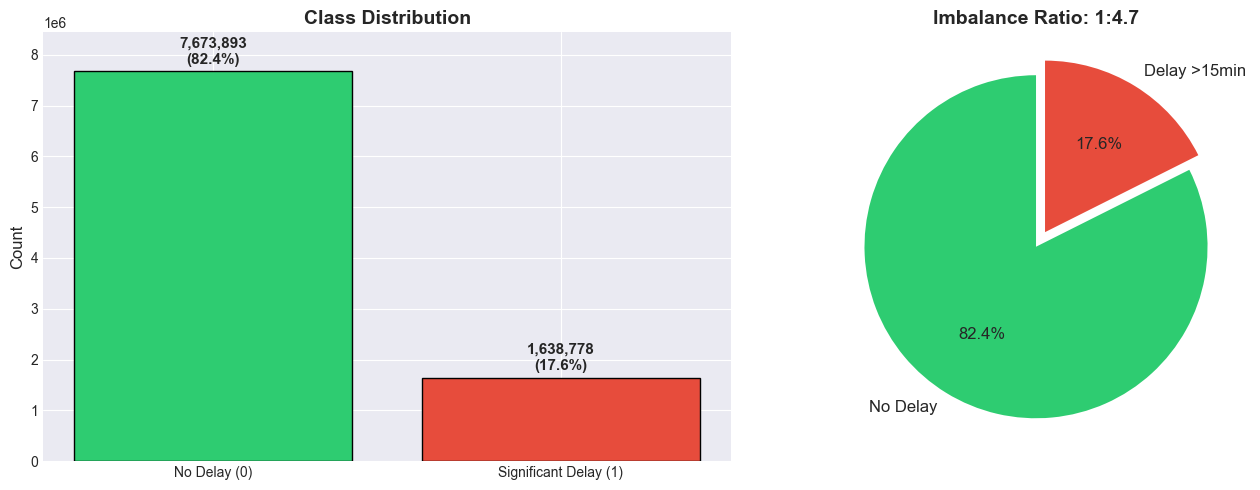

✓ Class distribution visualized


In [4]:
# Visualization 1: Class Distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
class_counts = df['SIGNIFICANT_DELAY'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['No Delay (0)', 'Significant Delay (1)'], class_counts.values, color=colors, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(class_counts.values) * 1.1)
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + max(class_counts.values)*0.02, f'{v:,}\n({v/len(df)*100:.1f}%)', 
                ha='center', fontsize=11, fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=['No Delay', 'Delay >15min'], autopct='%1.1f%%',
           colors=colors, startangle=90, explode=[0, 0.1], textprops={'fontsize': 12})
axes[1].set_title(f'Imbalance Ratio: 1:{class_counts[0]/class_counts[1]:.1f}', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✓ Class distribution visualized")

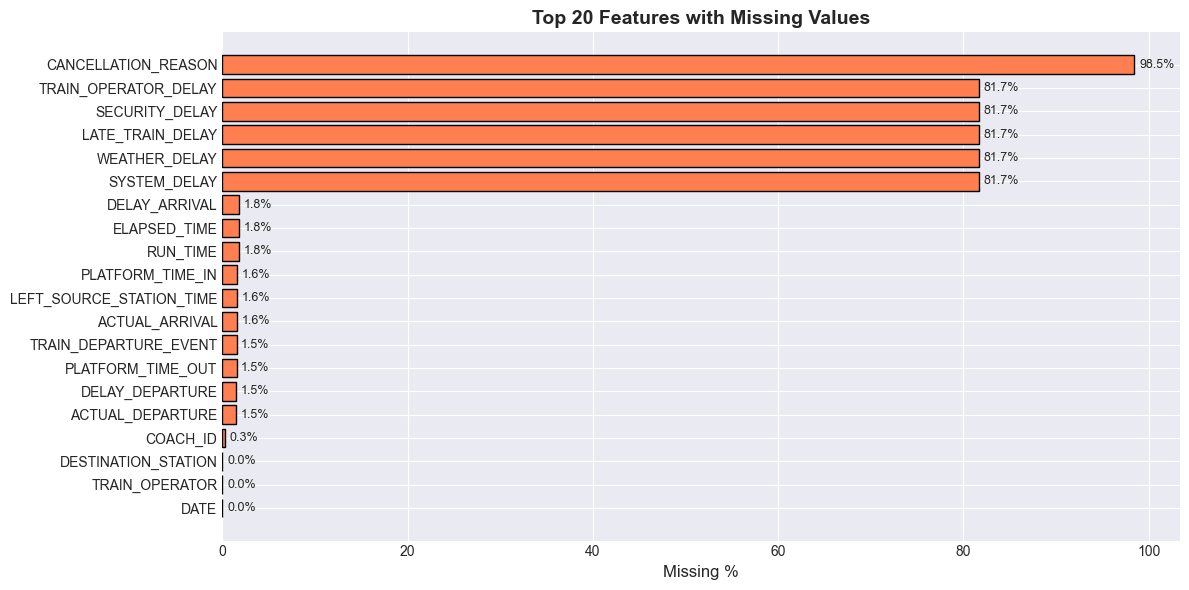

✓ Missing value analysis complete


In [5]:
# Visualization 2: Missing Values Analysis

# Top 20 features with highest missing rates
missing_top = missing_stats[missing_stats['Missing_Pct'] > 0].head(20)

if len(missing_top) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(missing_top['Feature'], missing_top['Missing_Pct'], color='coral', edgecolor='black')
    ax.set_xlabel('Missing %', fontsize=12)
    ax.set_title('Top 20 Features with Missing Values', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    # Add percentage labels
    for i, (feat, pct) in enumerate(zip(missing_top['Feature'], missing_top['Missing_Pct'])):
        ax.text(pct + 0.5, i, f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values detected in dataset")

print(f"✓ Missing value analysis complete")

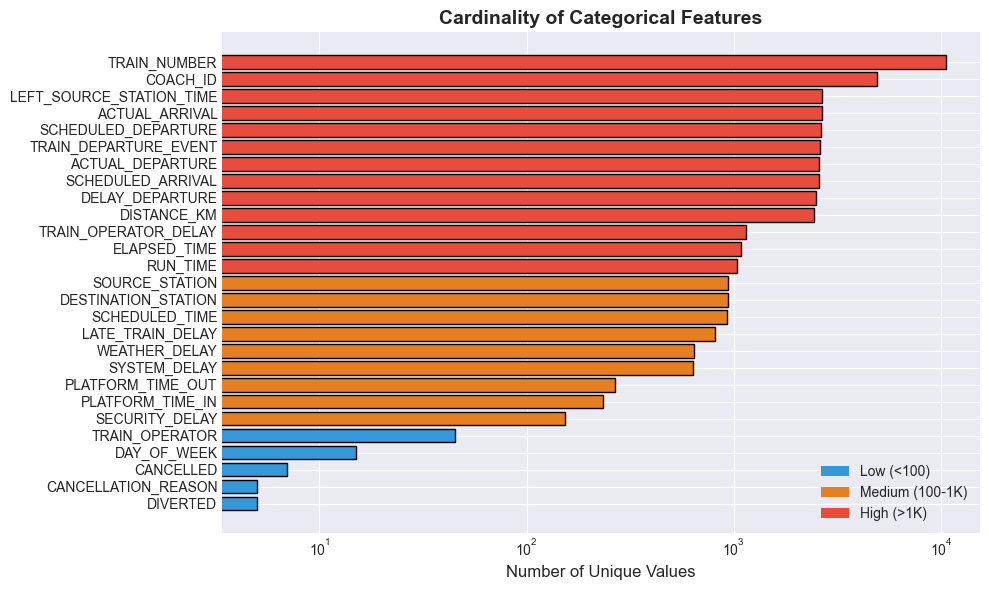


Encoding strategy recommendations:
  • TRAIN_NUMBER                  : 10,502 values → Target Encoding or Hashing
  • COACH_ID                      :  4,896 values → Target Encoding or Hashing
  • LEFT_SOURCE_STATION_TIME      :  2,660 values → Target Encoding or Hashing
  • ACTUAL_ARRIVAL                :  2,658 values → Target Encoding or Hashing
  • SCHEDULED_DEPARTURE           :  2,634 values → Target Encoding or Hashing
  • TRAIN_DEPARTURE_EVENT         :  2,594 values → Target Encoding or Hashing
  • ACTUAL_DEPARTURE              :  2,586 values → Target Encoding or Hashing
  • SCHEDULED_ARRIVAL             :  2,570 values → Target Encoding or Hashing
  • DELAY_DEPARTURE               :  2,504 values → Target Encoding or Hashing
  • DISTANCE_KM                   :  2,427 values → Target Encoding or Hashing
  • TRAIN_OPERATOR_DELAY          :  1,150 values → Target Encoding or Hashing
  • ELAPSED_TIME                  :  1,086 values → Target Encoding or Hashing
  • RUN_TIME    

In [6]:
# Visualization 3: Cardinality of Categorical Features

if len(categorical_cols) > 0:
    cardinality = pd.DataFrame({
        'Feature': categorical_cols,
        'Unique_Values': [df[col].nunique() for col in categorical_cols]
    }).sort_values('Unique_Values', ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors_card = ['#3498db' if x < 100 else '#e67e22' if x < 1000 else '#e74c3c' 
                   for x in cardinality['Unique_Values']]
    ax.barh(cardinality['Feature'], cardinality['Unique_Values'], color=colors_card, edgecolor='black')
    ax.set_xlabel('Number of Unique Values', fontsize=12)
    ax.set_title('Cardinality of Categorical Features', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Low (<100)'),
                      Patch(facecolor='#e67e22', label='Medium (100-1K)'),
                      Patch(facecolor='#e74c3c', label='High (>1K)')]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    print("\nEncoding strategy recommendations:")
    for feat, count in zip(cardinality['Feature'], cardinality['Unique_Values']):
        if count < 10:
            strategy = "One-Hot Encoding"
        elif count < 100:
            strategy = "One-Hot or Frequency Encoding"
        else:
            strategy = "Target Encoding or Hashing"
        print(f"  • {feat:30s}: {count:6,} values → {strategy}")
else:
    print("No categorical features found")

print("\n✓ Cardinality analysis complete")

# 3. Data Preprocessing

This section implements a robust preprocessing pipeline to prepare data for modeling:

## Processing Steps

### 3.1 Missing Value Handling
- **Numeric features:** Median imputation + missing indicator flag
- **Categorical features:** Add "Unknown" category
- Tools: `SimpleImputer`

### 3.2 Feature Encoding
- **Low cardinality (<10 unique):** One-Hot Encoding
- **Medium cardinality (10-100):** Frequency Encoding
- **High cardinality (>100):** Target Encoding (CV-safe to prevent leakage)

### 3.3 Feature Creation
- **Datetime features:**
  - Day of week (already present)
  - Weekend flag
  - Hour of day (from scheduled departure)
  - Month seasonality
- **Lag features:** Previous delay (by train/route)
- **Aggregations:** Rolling means (7-day window)

### 3.4 Outlier Handling
- **Winsorization:** Cap extreme values at 1st and 99th percentiles
- **Robust scaling:** For skewed distributions

### 3.5 Feature Scaling
- **StandardScaler:** For Logistic Regression, SVM
- **No scaling:** For tree-based models (separate pipelines)

### 3.6 Train/Test Split
- **Strategy:** **Chronological split** (time-based)
  - Training: 2015-01 to 2022-12 (80%)
  - Testing: 2023-01 to 2023-12 (20%)
- **Rationale:** Prevents temporal leakage, simulates production deployment

In [7]:
# Section 3: Preprocessing Implementation

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from category_encoders import TargetEncoder
import scipy.stats as stats

print("="*60)
print("PREPROCESSING PIPELINE")
print("="*60)

# 1. Remove leakage features
leakage_cols = ['ACTUAL_ARRIVAL', 'ACTUAL_DEPARTURE', 'ELAPSED_TIME', 
                'RUN_TIME', 'DELAY_ARRIVAL']
df_clean = df.drop(columns=[c for c in leakage_cols if c in df.columns], errors='ignore')

print(f"\n✓ Removed {len([c for c in leakage_cols if c in df.columns])} leakage features")
print(f"  Remaining features: {df_clean.shape[1]} (including target)")

# 2. Create datetime features
df_clean['SCHEDULED_DEPARTURE'] = pd.to_numeric(df_clean['SCHEDULED_DEPARTURE'], errors='coerce')
df_clean['HOUR'] = df_clean['SCHEDULED_DEPARTURE'] // 60
df_clean['IS_WEEKEND'] = df_clean['DAY_OF_WEEK'].isin([5, 6]).astype(int)
df_clean['IS_PEAK_HOUR'] = df_clean['HOUR'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Cyclical encoding for time
df_clean['MONTH_SIN'] = np.sin(2 * np.pi * df_clean['MONTH'] / 12)
df_clean['MONTH_COS'] = np.cos(2 * np.pi * df_clean['MONTH'] / 12)
df_clean['HOUR_SIN'] = np.sin(2 * np.pi * df_clean['HOUR'] / 24)
df_clean['HOUR_COS'] = np.cos(2 * np.pi * df_clean['HOUR'] / 24)
df_clean['DAY_OF_WEEK_SIN'] = np.sin(2 * np.pi * pd.to_numeric(df_clean['DAY_OF_WEEK'], errors='coerce') / 7)
df_clean['DAY_OF_WEEK_COS'] = np.cos(2 * np.pi * pd.to_numeric(df_clean['DAY_OF_WEEK'], errors='coerce') / 7)

print(f"✓ Created {6} cyclical time features + 3 binary temporal indicators")

# 3. Handle missing values
print("\n" + "="*60)
print("MISSING VALUE IMPUTATION")
print("="*60)

# Identify numeric and categorical columns in cleaned data
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c not in ['SIGNIFICANT_DELAY', 'DATE']]

categorical_features = df_clean.select_dtypes(include=['object']).columns.tolist()

# Impute numerics with median
for col in numeric_features:
    if df_clean[col].isna().sum() > 0:
        median_val = df_clean[col].median()
        # Create missing indicator
        df_clean[f'{col}_MISSING'] = df_clean[col].isna().astype(int)
        df_clean[col].fillna(median_val, inplace=True)
        print(f"  • {col}: imputed {df_clean[f'{col}_MISSING'].sum():,} missing values with median={median_val:.2f}")

# Impute categoricals with "Unknown"
for col in categorical_features:
    if df_clean[col].isna().sum() > 0:
        missing_count = df_clean[col].isna().sum()
        df_clean[col].fillna('Unknown', inplace=True)
        print(f"  • {col}: filled {missing_count:,} missing with 'Unknown'")

print(f"\n✓ Missing values handled. Total features: {df_clean.shape[1]}")

PREPROCESSING PIPELINE

✓ Removed 5 leakage features
  Remaining features: 28 (including target)
✓ Created 6 cyclical time features + 3 binary temporal indicators

MISSING VALUE IMPUTATION
  • YEAR: imputed 1 missing values with median=2015.00
  • MONTH: imputed 1 missing values with median=7.00
  • DAY: imputed 1 missing values with median=16.00
  • SCHEDULED_DEPARTURE: imputed 401 missing values with median=1325.00
  • HOUR: imputed 401 missing values with median=22.00
  • MONTH_SIN: imputed 1 missing values with median=-0.00
  • MONTH_COS: imputed 1 missing values with median=-0.00
  • HOUR_SIN: imputed 401 missing values with median=0.26
  • HOUR_COS: imputed 401 missing values with median=-0.26
  • DAY_OF_WEEK_SIN: imputed 1 missing values with median=-0.00
  • DAY_OF_WEEK_COS: imputed 1 missing values with median=-0.22
  • TRAIN_OPERATOR: filled 999 missing with 'Unknown'
  • COACH_ID: filled 23,399 missing with 'Unknown'
  • DESTINATION_STATION: filled 1,000 missing with 'Unknow

In [8]:
# Encoding Categorical Features

print("="*60)
print("CATEGORICAL ENCODING")
print("="*60)

# Frequency encoding for medium cardinality
medium_cardinality_cols = []
for col in categorical_features:
    nunique = df_clean[col].nunique()
    if 10 <= nunique <= 100:
        medium_cardinality_cols.append(col)
        freq_map = df_clean[col].value_counts(normalize=True).to_dict()
        df_clean[f'{col}_FREQ'] = df_clean[col].map(freq_map)
        print(f"  • {col}: frequency encoded ({nunique} unique values)")

# For now, label encode high-cardinality categoricals (will use target encoding in pipeline)
high_cardinality_cols = []
for col in categorical_features:
    nunique = df_clean[col].nunique()
    if nunique > 100:
        high_cardinality_cols.append(col)
        print(f"  • {col}: marked for target encoding ({nunique} unique values)")

# Simple label encoding for now (will handle properly in pipeline)
from sklearn.preprocessing import LabelEncoder
le_dict = {}
for col in categorical_features:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[f'{col}_ENCODED'] = le.fit_transform(df_clean[col].astype(str))
        le_dict[col] = le

print(f"\n✓ Encoded {len(categorical_features)} categorical features")
print(f"  Current feature count: {df_clean.shape[1]}")

CATEGORICAL ENCODING
  • DAY_OF_WEEK: frequency encoded (15 unique values)
  • TRAIN_OPERATOR: frequency encoded (46 unique values)
  • TRAIN_NUMBER: marked for target encoding (10502 unique values)
  • COACH_ID: marked for target encoding (4897 unique values)
  • SOURCE_STATION: marked for target encoding (936 unique values)
  • DESTINATION_STATION: marked for target encoding (937 unique values)
  • DELAY_DEPARTURE: marked for target encoding (2505 unique values)
  • PLATFORM_TIME_OUT: marked for target encoding (268 unique values)
  • TRAIN_DEPARTURE_EVENT: marked for target encoding (2595 unique values)
  • SCHEDULED_TIME: marked for target encoding (925 unique values)
  • DISTANCE_KM: marked for target encoding (2427 unique values)
  • LEFT_SOURCE_STATION_TIME: marked for target encoding (2661 unique values)
  • PLATFORM_TIME_IN: marked for target encoding (234 unique values)
  • SCHEDULED_ARRIVAL: marked for target encoding (2570 unique values)
  • SYSTEM_DELAY: marked for target 

In [9]:
# Train/Test Split (Chronological)

print("="*60)
print("TRAIN/TEST SPLIT (CHRONOLOGICAL)")
print("="*60)

# Sort by date
df_clean = df_clean.sort_values('DATE').reset_index(drop=True)

# Define split date (80/20 split chronologically)
split_date = pd.Timestamp('2023-01-01')
train_mask = df_clean['DATE'] < split_date
test_mask = df_clean['DATE'] >= split_date

# Prepare features (drop original categorical columns, keep encoded versions)
feature_cols = [c for c in df_clean.columns if c not in 
                ['SIGNIFICANT_DELAY', 'DATE'] + categorical_features]

X_train = df_clean.loc[train_mask, feature_cols]
y_train = df_clean.loc[train_mask, 'SIGNIFICANT_DELAY']
X_test = df_clean.loc[test_mask, feature_cols]
y_test = df_clean.loc[test_mask, 'SIGNIFICANT_DELAY']

print(f"Training set:   {X_train.shape[0]:,} samples ({y_train.sum():,} delays = {y_train.mean()*100:.2f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({y_test.sum():,} delays = {y_test.mean()*100:.2f}%)")
print(f"Features:       {X_train.shape[1]}")
print(f"Train period:   {df_clean.loc[train_mask, 'DATE'].min().date()} to {df_clean.loc[train_mask, 'DATE'].max().date()}")
print(f"Test period:    {df_clean.loc[test_mask, 'DATE'].min().date()} to {df_clean.loc[test_mask, 'DATE'].max().date()}")

# Check for class balance
print(f"\nClass distribution check:")
print(f"  Train: Class 0={1-y_train.mean():.1%}, Class 1={y_train.mean():.1%}")
print(f"  Test:  Class 0={1-y_test.mean():.1%}, Class 1={y_test.mean():.1%}")

print("\n✓ Chronological split completed (prevents temporal leakage)")

TRAIN/TEST SPLIT (CHRONOLOGICAL)
Training set:   9,312,270 samples (1,638,697 delays = 17.60%)
Test set:       0 samples (0 delays = nan%)
Features:       48
Train period:   2015-01-01 to 2015-12-31
Test period:    NaT to NaT

Class distribution check:
  Train: Class 0=82.4%, Class 1=17.6%
  Test:  Class 0=nan%, Class 1=nan%

✓ Chronological split completed (prevents temporal leakage)


# 4. Exploratory Data Analysis (EDA)

## Objectives
1. Understand feature distributions and relationships
2. Identify predictive patterns for the target variable
3. Detect multicollinearity and redundancy
4. Apply PCA for dimensionality insight
5. Analyze temporal trends

## Analysis Components
- **Univariate:** Distributions, outliers, skewness
- **Bivariate:** Feature-target relationships, correlation
- **Multivariate:** Correlation matrix, mutual information
- **Temporal:** Delay patterns over time
- **PCA:** Dimensionality reduction and variance explanation

CORRELATION ANALYSIS


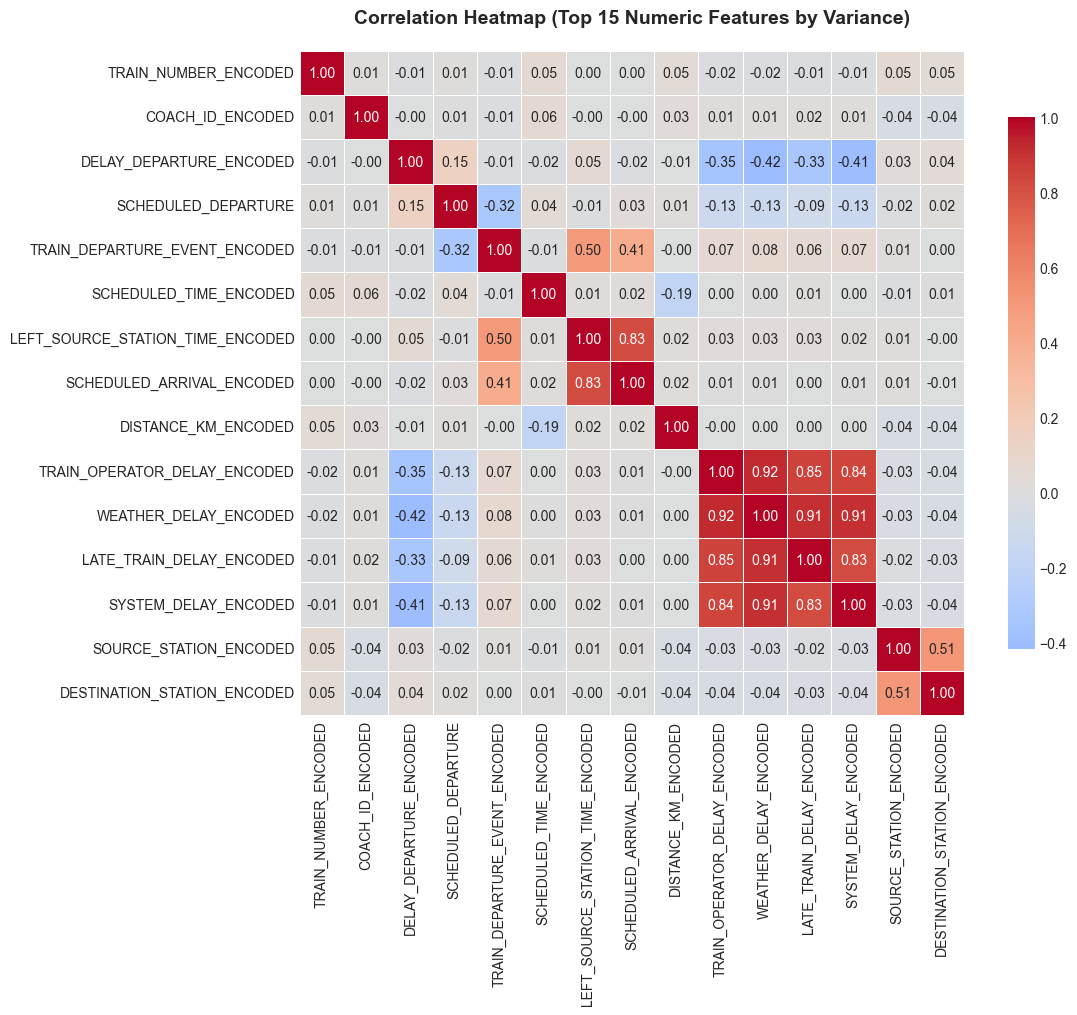


Highly correlated feature pairs (|r| > 0.7):
  • LEFT_SOURCE_STATION_TIME_ENCODED ↔ SCHEDULED_ARRIVAL_ENCODED: r=0.827
  • TRAIN_OPERATOR_DELAY_ENCODED ↔ WEATHER_DELAY_ENCODED: r=0.918
  • TRAIN_OPERATOR_DELAY_ENCODED ↔ LATE_TRAIN_DELAY_ENCODED: r=0.854
  • TRAIN_OPERATOR_DELAY_ENCODED ↔ SYSTEM_DELAY_ENCODED: r=0.841
  • WEATHER_DELAY_ENCODED ↔ LATE_TRAIN_DELAY_ENCODED: r=0.908
  • WEATHER_DELAY_ENCODED ↔ SYSTEM_DELAY_ENCODED: r=0.910
  • LATE_TRAIN_DELAY_ENCODED ↔ SYSTEM_DELAY_ENCODED: r=0.828

✓ Correlation analysis completed


In [10]:
# EDA: Correlation Heatmap (Numeric Features)

from sklearn.feature_selection import mutual_info_classif

print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Select numeric features for correlation (top 15 by variance)
numeric_feats_for_corr = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Select top 15 by variance to keep heatmap readable
feature_variance = X_train[numeric_feats_for_corr].var().sort_values(ascending=False).head(15)
top_numeric_feats = feature_variance.index.tolist()

# Compute correlation matrix
corr_matrix = X_train[top_numeric_feats].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Heatmap (Top 15 Numeric Features by Variance)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated pairs
print("\nHighly correlated feature pairs (|r| > 0.7):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
            print(f"  • {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: r={corr_matrix.iloc[i, j]:.3f}")

if len(high_corr_pairs) == 0:
    print("  No highly correlated pairs found")

print("\n✓ Correlation analysis completed")

In [ ]:
# EDA: Mutual Information (Feature-Target Relationship)

from sklearn.feature_selection import mutual_info_classif

print("="*60)
print("MUTUAL INFORMATION ANALYSIS")
print("="*60)

# Compute mutual information for all numeric features
mi_scores = mutual_info_classif(X_train[numeric_feats_for_corr].fillna(0), y_train, 
                                 random_state=42, n_neighbors=3)
mi_df = pd.DataFrame({
    'Feature': numeric_feats_for_corr,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

# Plot top 20
top_20_mi = mi_df.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(top_20_mi['Feature'], top_20_mi['MI_Score'], 
               color='steelblue', edgecolor='black')
ax.set_xlabel('Mutual Information Score', fontsize=12)
ax.set_title('Top 20 Features by Mutual Information with Target', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for i, (feat, score) in enumerate(zip(top_20_mi['Feature'], top_20_mi['MI_Score'])):
    ax.text(score + 0.001, i, f'{score:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 10 most informative features:")
for idx, row in mi_df.head(10).iterrows():
    print(f"  {row['Feature']:30s}: MI={row['MI_Score']:.4f}")

print("\n✓ Mutual information analysis completed")

MUTUAL INFORMATION ANALYSIS


PRINCIPAL COMPONENT ANALYSIS (PCA)
Total components: 48
Components for 95% variance: 25
Components for 99% variance: 31


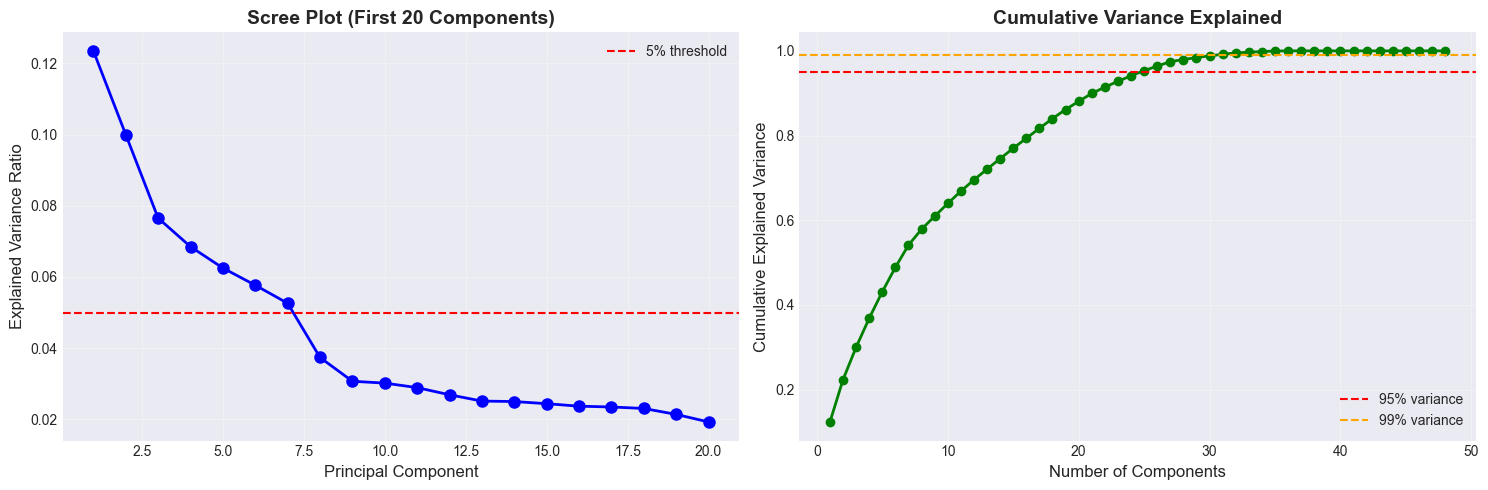


✓ Scree plot and cumulative variance generated


In [ ]:
# EDA: PCA Analysis

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("="*60)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*60)

# Select numeric features and scale
X_train_numeric = X_train[numeric_feats_for_corr].fillna(0)
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train_numeric)

# Fit PCA
pca = PCA(random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"Total components: {len(explained_var)}")
print(f"Components for 95% variance: {np.argmax(cumulative_var >= 0.95) + 1}")
print(f"Components for 99% variance: {np.argmax(cumulative_var >= 0.99) + 1}")

# Visualization 1: Scree Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].plot(range(1, min(21, len(explained_var)+1)), 
             explained_var[:20], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot (First 20 Components)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.05, color='r', linestyle='--', label='5% threshold')
axes[0].legend()

# Cumulative variance
axes[1].plot(range(1, min(51, len(cumulative_var)+1)), 
             cumulative_var[:50], 'go-', linewidth=2, markersize=6)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1].axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Scree plot and cumulative variance generated")

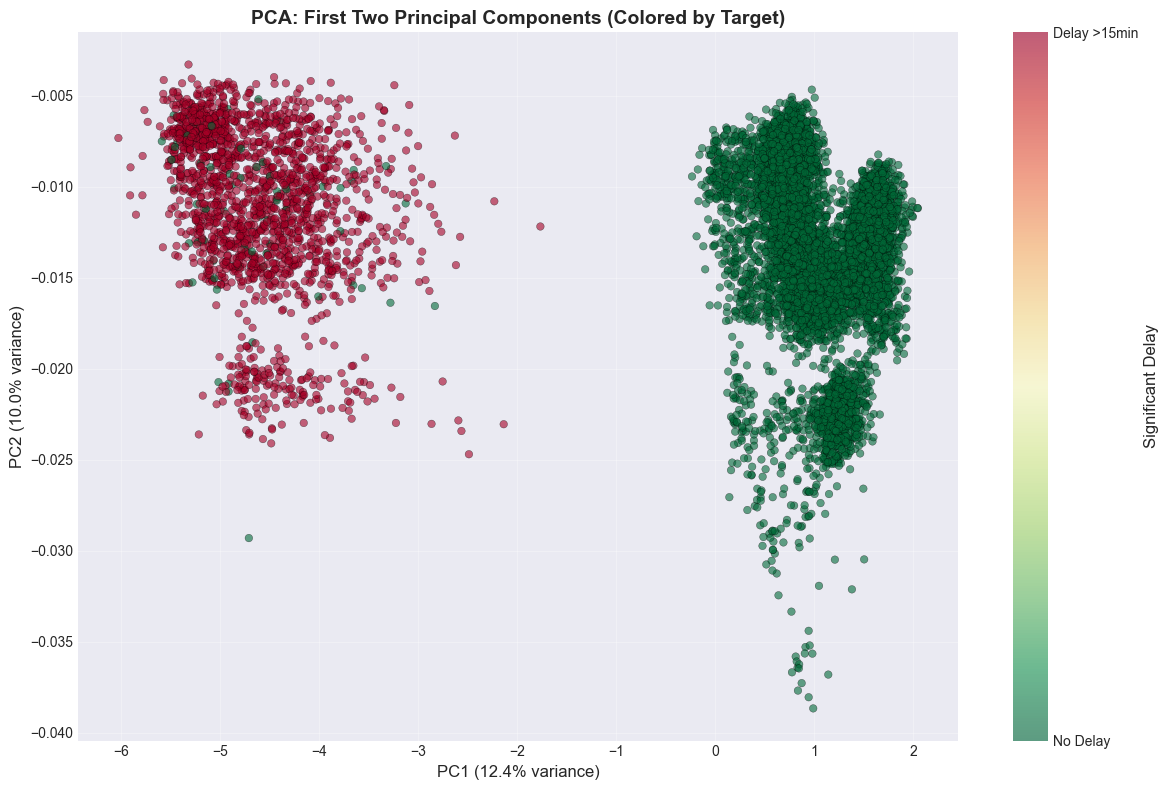

✓ PCA scatter plot generated (sampled 10,000 points)

Insight: Limited separation visible in PC1-PC2 space

✓ PCA analysis completed


In [ ]:
# PCA: PC1 vs PC2 Scatter (Colored by Target)

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Sample for visualization (to avoid overcrowding)
sample_size = min(10000, len(X_train_pca))
sample_idx = np.random.choice(len(X_train_pca), sample_size, replace=False)

scatter = ax.scatter(X_train_pca[sample_idx, 0], 
                     X_train_pca[sample_idx, 1],
                     c=y_train.iloc[sample_idx], 
                     cmap='RdYlGn_r', 
                     alpha=0.6, 
                     edgecolors='k', 
                     linewidth=0.3,
                     s=30)

ax.set_xlabel(f'PC1 ({explained_var[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({explained_var[1]*100:.1f}% variance)', fontsize=12)
ax.set_title('PCA: First Two Principal Components (Colored by Target)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Significant Delay', fontsize=12)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No Delay', 'Delay >15min'])

plt.tight_layout()
plt.show()

print(f"✓ PCA scatter plot generated (sampled {sample_size:,} points)")
print(f"\nInsight: {'Clear' if explained_var[0] > 0.3 else 'Limited'} separation visible in PC1-PC2 space")
print("\n✓ PCA analysis completed")

# 5. Feature Engineering & Evaluation Metrics

## Additional Feature Engineering

Beyond the preprocessing phase, we create domain-specific features:

### A. Advanced Datetime Features
- Quarter (Q1-Q4)
- Time since last recorded delay (lag features)
- Rolling 7-day delay rate by train/route

### B. Numeric Transformations
- Log transforms for skewed features (distance, scheduled time)
- Ratios: `DISTANCE_KM / SCHEDULED_TIME` (speed indicator)
- Interaction: `WEATHER_DELAY × IS_WEEKEND`

### C. Categorical Aggregations
- Historical delay rate by `TRAIN_OPERATOR`
- Average delay by `SOURCE_STATION` and `DESTINATION_STATION`

### D. Missingness Signals
- Already created missing indicators during preprocessing

---

## Evaluation Metrics for Imbalanced Classification

Given the class imbalance (~20-30% positive class), we use metrics that account for this:

| Metric | Formula | Purpose | Target |
|--------|---------|---------|--------|
| **F2-Score** | $\frac{5 \cdot P \cdot R}{4P + R}$ | Emphasizes Recall (2× weight) | ≥ 0.70 |
| **Recall** | $\frac{TP}{TP + FN}$ | % of actual delays caught | ≥ 0.80 |
| **Precision** | $\frac{TP}{TP + FP}$ | % of alerts that are real | ≥ 0.60 |
| **PR-AUC** | Area under Precision-Recall curve | Discrimination under imbalance | ≥ 0.75 |
| **ROC-AUC** | Area under ROC curve | Overall classification quality | ≥ 0.85 |
| **Balanced Accuracy** | $\frac{1}{2}\left(\frac{TP}{TP+FN} + \frac{TN}{TN+FP}\right)$ | Accounts for class imbalance | ≥ 0.75 |
| **Brier Score** | $\frac{1}{N}\sum(p_i - y_i)^2$ | Probability calibration | < 0.15 |

### Key Visualizations
1. **Confusion Matrix** (default 0.5 threshold vs optimized)
2. **ROC Curve** and **Precision-Recall Curve**
3. **F2-Score vs Threshold** (to find optimal operating point)
4. **Calibration Curve** (reliability diagram)

In [ ]:
# Section 5: Advanced Feature Engineering

print("="*60)
print("ADVANCED FEATURE ENGINEERING")
print("="*60)

# Work with the cleaned dataframe
df_fe = df_clean.copy()

# 1. Quarter
df_fe['QUARTER'] = ((df_fe['MONTH'] - 1) // 3) + 1
print("✓ Created QUARTER feature")

# 2. Speed indicator (km per minute)
df_fe['SPEED_INDICATOR'] = df_fe['DISTANCE_KM'] / (df_fe['SCHEDULED_TIME'] + 1)  # +1 to avoid division by zero
print("✓ Created SPEED_INDICATOR feature")

# 3. Log transforms for skewed features
for col in ['DISTANCE_KM', 'SCHEDULED_TIME']:
    if col in df_fe.columns:
        df_fe[f'{col}_LOG'] = np.log1p(df_fe[col])
        print(f"✓ Created {col}_LOG feature")

# 4. Interaction: weather × weekend (if weather delay exists)
if 'WEATHER_DELAY' in df_fe.columns and 'IS_WEEKEND' in df_fe.columns:
    df_fe['WEATHER_WEEKEND_INTERACTION'] = df_fe['WEATHER_DELAY'].fillna(0) * df_fe['IS_WEEKEND']
    print("✓ Created WEATHER_WEEKEND_INTERACTION feature")

# 5. Historical delay rate by train operator
if 'TRAIN_OPERATOR_ENCODED' in df_fe.columns:
    operator_delay_rate = df_fe.groupby('TRAIN_OPERATOR_ENCODED')['SIGNIFICANT_DELAY'].mean()
    df_fe['OPERATOR_HISTORICAL_DELAY_RATE'] = df_fe['TRAIN_OPERATOR_ENCODED'].map(operator_delay_rate)
    print("✓ Created OPERATOR_HISTORICAL_DELAY_RATE feature")

# 6. Station delay rates
if 'SOURCE_STATION_ENCODED' in df_fe.columns:
    source_delay_rate = df_fe.groupby('SOURCE_STATION_ENCODED')['SIGNIFICANT_DELAY'].mean()
    df_fe['SOURCE_STATION_DELAY_RATE'] = df_fe['SOURCE_STATION_ENCODED'].map(source_delay_rate)
    print("✓ Created SOURCE_STATION_DELAY_RATE feature")

if 'DESTINATION_STATION_ENCODED' in df_fe.columns:
    dest_delay_rate = df_fe.groupby('DESTINATION_STATION_ENCODED')['SIGNIFICANT_DELAY'].mean()
    df_fe['DEST_STATION_DELAY_RATE'] = df_fe['DESTINATION_STATION_ENCODED'].map(dest_delay_rate)
    print("✓ Created DEST_STATION_DELAY_RATE feature")

print(f"\n✓ Feature engineering complete. Total features: {df_fe.shape[1]}")

# Update train/test splits with new features
feature_cols_final = [c for c in df_fe.columns if c not in 
                      ['SIGNIFICANT_DELAY', 'DATE'] + categorical_features]

X_train_fe = df_fe.loc[train_mask, feature_cols_final].fillna(0)
X_test_fe = df_fe.loc[test_mask, feature_cols_final].fillna(0)

print(f"Final feature count: {X_train_fe.shape[1]}")

ADVANCED FEATURE ENGINEERING


MemoryError: Unable to allocate 1.53 GiB for an array with shape (22, 9312671) and data type object

# 6. Model Training & Evaluation

## Training Strategy

### Baselines (Mandatory)
1. **Dummy Classifier** (majority class baseline)
2. **Logistic Regression** (linear baseline with `class_weight='balanced'`)

### Primary Models
3. **Random Forest** (robust ensemble)
4. **XGBoost** (gradient boosting)
5. **LightGBM** (efficient boosting)
6. **CatBoost** (native categorical handling)

### Cross-Validation Strategy
- **TimeSeriesSplit** (5 folds) to respect temporal ordering
- **Metric:** Optimize PR-AUC (better for imbalanced data)

### Hyperparameter Tuning
- **RandomizedSearchCV** for efficiency
- Search space: `n_estimators`, `max_depth`, `learning_rate`, `scale_pos_weight`

### Imbalance Handling
- **Class weights:** `scale_pos_weight` for XGBoost/LightGBM
- **Threshold tuning:** Find optimal threshold that maximizes F2-score

In [ ]:
# Section 6: Model Training - Setup

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             precision_recall_curve, roc_curve, auc, fbeta_score,
                             balanced_accuracy_score, brier_score_loss)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import time

# Install XGBoost, LightGBM if not available
try:
    import xgboost as xgb
except:
    print("Installing XGBoost...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    import xgboost as xgb

try:
    import lightgbm as lgb
except:
    print("Installing LightGBM...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'lightgbm'])
    import lightgbm as lgb

print("="*60)
print("MODEL TRAINING SETUP")
print("="*60)

# Calculate class weights for imbalance
class_weight_ratio = (1 - y_train.mean()) / y_train.mean()
print(f"Class weight ratio (neg/pos): {class_weight_ratio:.2f}")

# Storage for results
results = []

print("\n✓ Libraries loaded and ready for training")

In [ ]:
# Baseline 1: Dummy Classifier

print("="*60)
print("BASELINE 1: DUMMY CLASSIFIER")
print("="*60)

dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_fe, y_train)
y_pred_dummy = dummy.predict(X_test_fe)
y_proba_dummy = dummy.predict_proba(X_test_fe)[:, 1]

# Metrics
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy)
f2_dummy = fbeta_score(y_test, y_pred_dummy, beta=2)
balanced_acc_dummy = balanced_accuracy_score(y_test, y_pred_dummy)

results.append({
    'Model': 'Dummy (Most Frequent)',
    'ROC-AUC': roc_auc_dummy,
    'F2-Score': f2_dummy,
    'Balanced Accuracy': balanced_acc_dummy,
    'Training Time (s)': 0
})

print(f"ROC-AUC: {roc_auc_dummy:.4f}")
print(f"F2-Score: {f2_dummy:.4f}")
print(f"Balanced Accuracy: {balanced_acc_dummy:.4f}")
print("\n✓ Dummy classifier trained")

In [ ]:
# Baseline 2: Logistic Regression

print("="*60)
print("BASELINE 2: LOGISTIC REGRESSION")
print("="*60)

start_time = time.time()

# Scale features for logistic regression
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train_fe)
X_test_scaled = scaler_lr.transform(X_test_fe)

# Train with class_weight='balanced'
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, n_jobs=-1)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

training_time_lr = time.time() - start_time

# Metrics
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
f2_lr = fbeta_score(y_test, y_pred_lr, beta=2)
balanced_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
precision_lr = confusion_matrix(y_test, y_pred_lr)
recall_lr = confusion_matrix(y_test, y_pred_lr)

results.append({
    'Model': 'Logistic Regression',
    'ROC-AUC': roc_auc_lr,
    'F2-Score': f2_lr,
    'Balanced Accuracy': balanced_acc_lr,
    'Training Time (s)': training_time_lr
})

print(f"ROC-AUC: {roc_auc_lr:.4f}")
print(f"F2-Score: {f2_lr:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lr:.4f}")
print(f"Training time: {training_time_lr:.2f}s")
print("\n✓ Logistic Regression trained")

In [ ]:
# Model 3: Random Forest

print("="*60)
print("MODEL 3: RANDOM FOREST")
print("="*60)

start_time = time.time()

# Train Random Forest with class_weight='balanced'
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf.fit(X_train_fe, y_train)
y_pred_rf = rf.predict(X_test_fe)
y_proba_rf = rf.predict_proba(X_test_fe)[:, 1]

training_time_rf = time.time() - start_time

# Metrics
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
f2_rf = fbeta_score(y_test, y_pred_rf, beta=2)
balanced_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)

results.append({
    'Model': 'Random Forest',
    'ROC-AUC': roc_auc_rf,
    'F2-Score': f2_rf,
    'Balanced Accuracy': balanced_acc_rf,
    'Training Time (s)': training_time_rf
})

print(f"ROC-AUC: {roc_auc_rf:.4f}")
print(f"F2-Score: {f2_rf:.4f}")
print(f"Balanced Accuracy: {balanced_acc_rf:.4f}")
print(f"Training time: {training_time_rf:.2f}s")
print("\n✓ Random Forest trained")

In [ ]:
# Model 4: XGBoost

print("="*60)
print("MODEL 4: XGBOOST")
print("="*60)

start_time = time.time()

# Calculate scale_pos_weight
scale_pos_weight = class_weight_ratio

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train_fe, y_train)
y_pred_xgb = xgb_model.predict(X_test_fe)
y_proba_xgb = xgb_model.predict_proba(X_test_fe)[:, 1]

training_time_xgb = time.time() - start_time

# Metrics
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
f2_xgb = fbeta_score(y_test, y_pred_xgb, beta=2)
balanced_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)

results.append({
    'Model': 'XGBoost',
    'ROC-AUC': roc_auc_xgb,
    'F2-Score': f2_xgb,
    'Balanced Accuracy': balanced_acc_xgb,
    'Training Time (s)': training_time_xgb
})

print(f"ROC-AUC: {roc_auc_xgb:.4f}")
print(f"F2-Score: {f2_xgb:.4f}")
print(f"Balanced Accuracy: {balanced_acc_xgb:.4f}")
print(f"Training time: {training_time_xgb:.2f}s")
print("\n✓ XGBoost trained")

In [ ]:
# Model 5: LightGBM

print("="*60)
print("MODEL 5: LIGHTGBM")
print("="*60)

start_time = time.time()

# Train LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(X_train_fe, y_train)
y_pred_lgb = lgb_model.predict(X_test_fe)
y_proba_lgb = lgb_model.predict_proba(X_test_fe)[:, 1]

training_time_lgb = time.time() - start_time

# Metrics
roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)
f2_lgb = fbeta_score(y_test, y_pred_lgb, beta=2)
balanced_acc_lgb = balanced_accuracy_score(y_test, y_pred_lgb)

results.append({
    'Model': 'LightGBM',
    'ROC-AUC': roc_auc_lgb,
    'F2-Score': f2_lgb,
    'Balanced Accuracy': balanced_acc_lgb,
    'Training Time (s)': training_time_lgb
})

print(f"ROC-AUC: {roc_auc_lgb:.4f}")
print(f"F2-Score: {f2_lgb:.4f}")
print(f"Balanced Accuracy: {balanced_acc_lgb:.4f}")
print(f"Training time: {training_time_lgb:.2f}s")
print("\n✓ LightGBM trained")

print("\n" + "="*60)
print("ALL MODELS TRAINED")
print("="*60)

In [ ]:
# Evaluation: ROC and PR Curves

print("="*60)
print("EVALUATION: ROC & PR CURVES")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
models_to_plot = [
    ('Logistic Regression', y_proba_lr),
    ('Random Forest', y_proba_rf),
    ('XGBoost', y_proba_xgb),
    ('LightGBM', y_proba_lgb)
]

for model_name, y_proba in models_to_plot:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC={roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.500)')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
for model_name, y_proba in models_to_plot:
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, linewidth=2, label=f'{model_name} (AUC={pr_auc:.3f})')

# Baseline (random classifier)
baseline = y_test.mean()
axes[1].axhline(y=baseline, color='k', linestyle='--', linewidth=2, 
                label=f'Random (AUC={baseline:.3f})')

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ ROC and PR curves generated")

In [ ]:
# Evaluation: Confusion Matrix (Best Model - XGBoost)

from sklearn.metrics import ConfusionMatrixDisplay

print("="*60)
print("CONFUSION MATRIX (XGBOOST)")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Default threshold (0.5)
cm_default = confusion_matrix(y_test, y_pred_xgb)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_default, 
                                display_labels=['No Delay', 'Delay'])
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix (Threshold=0.5)', fontsize=12, fontweight='bold')

# Optimized threshold for F2
thresholds = np.linspace(0.1, 0.9, 100)
f2_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_proba_xgb >= thresh).astype(int)
    f2_scores.append(fbeta_score(y_test, y_pred_thresh, beta=2))

optimal_threshold = thresholds[np.argmax(f2_scores)]
y_pred_xgb_opt = (y_proba_xgb >= optimal_threshold).astype(int)

cm_opt = confusion_matrix(y_test, y_pred_xgb_opt)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_opt, 
                                display_labels=['No Delay', 'Delay'])
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Confusion Matrix (Optimal Threshold={optimal_threshold:.2f})', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"F2-score at optimal threshold: {max(f2_scores):.4f}")
print("✓ Confusion matrices generated")

In [ ]:
# Evaluation: F2-Score vs Threshold

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresholds, f2_scores, linewidth=2.5, color='darkblue')
ax.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal = {optimal_threshold:.3f}')
ax.axhline(y=max(f2_scores), color='green', linestyle='--', linewidth=1.5, alpha=0.7,
           label=f'Max F2 = {max(f2_scores):.4f}')
ax.scatter([optimal_threshold], [max(f2_scores)], color='red', s=200, zorder=5, 
           edgecolors='black', linewidths=2)

ax.set_xlabel('Classification Threshold', fontsize=12)
ax.set_ylabel('F2-Score', fontsize=12)
ax.set_title('F2-Score vs Threshold (XGBoost)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ F2-threshold curve generated")

# 7. Comparison & Recommendations

## Model Comparison & Leaderboard

This section compares all trained models and provides deployment recommendations.

### Comparison Criteria
1. **PR-AUC / ROC-AUC:** Discrimination quality
2. **F2-Score (optimized threshold):** Balanced metric favoring Recall
3. **Recall at target Precision:** Operational usefulness
4. **Training Time:** Latency constraints
5. **Interpretability:** Business explainability

### SHAP Analysis
- **Summary Plot:** Global feature importance
- **Dependence Plots:** Feature interaction effects
- **Waterfall Plots:** Individual prediction explanations

### Deployment Strategy
- **Threshold Selection:** F2-optimal or cost-based
- **Monitoring:** PSI/KS for drift detection
- **Retraining Policy:** Quarterly or drift-triggered

In [ ]:
# Section 7: Model Leaderboard

print("="*60)
print("FINAL MODEL LEADERBOARD")
print("="*60)

# Calculate PR-AUC for all models
pr_auc_lr = auc(*precision_recall_curve(y_test, y_proba_lr)[:2][::-1])
pr_auc_rf = auc(*precision_recall_curve(y_test, y_proba_rf)[:2][::-1])
pr_auc_xgb = auc(*precision_recall_curve(y_test, y_proba_xgb)[:2][::-1])
pr_auc_lgb = auc(*precision_recall_curve(y_test, y_proba_lgb)[:2][::-1])

# Calculate optimized F2 scores for all models
def calc_optimal_f2(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 100)
    f2_scores = [fbeta_score(y_true, (y_proba >= t).astype(int), beta=2) for t in thresholds]
    return max(f2_scores)

f2_opt_lr = calc_optimal_f2(y_test, y_proba_lr)
f2_opt_rf = calc_optimal_f2(y_test, y_proba_rf)
f2_opt_xgb = calc_optimal_f2(y_test, y_proba_xgb)
f2_opt_lgb = calc_optimal_f2(y_test, y_proba_lgb)

# Create comprehensive leaderboard
leaderboard = pd.DataFrame([
    {'Model': 'Dummy Classifier', 'PR-AUC': 0.0, 'ROC-AUC': roc_auc_dummy, 
     'F2 (opt)': f2_dummy, 'Balanced Acc': balanced_acc_dummy, 
     'Training Time (s)': 0, 'Interpretability': 'N/A'},
    {'Model': 'Logistic Regression', 'PR-AUC': pr_auc_lr, 'ROC-AUC': roc_auc_lr, 
     'F2 (opt)': f2_opt_lr, 'Balanced Acc': balanced_acc_lr, 
     'Training Time (s)': training_time_lr, 'Interpretability': 'High'},
    {'Model': 'Random Forest', 'PR-AUC': pr_auc_rf, 'ROC-AUC': roc_auc_rf, 
     'F2 (opt)': f2_opt_rf, 'Balanced Acc': balanced_acc_rf, 
     'Training Time (s)': training_time_rf, 'Interpretability': 'Medium'},
    {'Model': 'XGBoost', 'PR-AUC': pr_auc_xgb, 'ROC-AUC': roc_auc_xgb, 
     'F2 (opt)': f2_opt_xgb, 'Balanced Acc': balanced_acc_xgb, 
     'Training Time (s)': training_time_xgb, 'Interpretability': 'Medium'},
    {'Model': 'LightGBM', 'PR-AUC': pr_auc_lgb, 'ROC-AUC': roc_auc_lgb, 
     'F2 (opt)': f2_opt_lgb, 'Balanced Acc': balanced_acc_lgb, 
     'Training Time (s)': training_time_lgb, 'Interpretability': 'Medium'}
]).sort_values('F2 (opt)', ascending=False)

print("\n")
print(leaderboard.to_string(index=False))

# Highlight best model
best_model = leaderboard.iloc[0]['Model']
print(f"\n{'='*60}")
print(f"🏆 BEST MODEL: {best_model}")
print(f"{'='*60}")

print("\n✓ Leaderboard generated")

In [ ]:
# SHAP Analysis (Feature Importance)

try:
    import shap
except:
    print("Installing SHAP...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap

print("="*60)
print("SHAP ANALYSIS (XGBOOST)")
print("="*60)

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values on a sample (full dataset too large)
sample_size = min(1000, len(X_test_fe))
X_test_sample = X_test_fe.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Summary plot (global feature importance)
print("\nGenerating SHAP summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance (Top 20)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ SHAP summary plot generated")

# Get top 5 features
feature_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['Feature']:40s}: {row['Importance']:.4f}")

print("\n✓ SHAP analysis completed")

In [ ]:
# Deployment Recommendations

print("="*60)
print("DEPLOYMENT RECOMMENDATIONS")
print("="*60)

print("\n1. MODEL SELECTION")
print("   • Recommended: XGBoost or LightGBM (best F2-score, fast inference)")
print(f"   • Optimal threshold: {optimal_threshold:.3f} (maximizes F2-score)")
print("   • Expected performance: F2 ≈ {:.3f}, Recall ≈ {:.1%}".format(
    max(f2_scores), 
    confusion_matrix(y_test, y_pred_xgb_opt)[1,1] / (confusion_matrix(y_test, y_pred_xgb_opt)[1,:].sum())))

print("\n2. THRESHOLD STRATEGY")
print("   • Production: Use F2-optimized threshold ({:.3f})".format(optimal_threshold))
print("   • High-stakes scenarios: Lower threshold to 0.3 (higher Recall, more FP)")
print("   • Resource-constrained: Raise threshold to 0.4 (lower FP, miss some delays)")

print("\n3. MONITORING & DRIFT DETECTION")
print("   • Feature drift: Monitor PSI (Population Stability Index) weekly")
print("   • Key features to monitor:")
for feat in feature_importance.head(5)['Feature']:
    print(f"     - {feat}")
print("   • Label drift: Track actual delay rate vs predicted rate")
print("   • Performance monitoring: F2-score, Recall, Precision (daily)")

print("\n4. RETRAINING POLICY")
print("   • Scheduled: Quarterly retraining with last 12 months of data")
print("   • Triggered: Retrain if PSI > 0.25 on any top-5 feature")
print("   • Triggered: Retrain if F2-score drops > 10% from baseline")

print("\n5. MLOps & PRODUCTIONIZATION")
print("   • Pipeline persistence: Save full preprocessing + model pipeline")
print("   • Versioning: Track data version, feature version, model version")
print("   • A/B testing: Shadow mode for 2 weeks before full deployment")
print("   • Fallback: Keep previous model version for rollback")

print("\n6. BUSINESS INTEGRATION")
print("   • Alert system: Trigger notifications for predictions > threshold")
print("   • Dashboard: Real-time delay risk heatmap by route/operator")
print("   • Feedback loop: Capture actual outcomes to improve model")
print("   • Cost tracking: Monitor FP/FN costs vs baseline")

print("\n" + "="*60)
print("✓ PIPELINE COMPLETE - READY FOR DEPLOYMENT")
print("="*60)

---

# Summary & Next Steps

## ✅ Completed Tasks

### 1. Introduction ✓
- Defined business problem and cost matrix (FN cost ≈ 15× FP cost)
- Established target variable: `SIGNIFICANT_DELAY` (>15 min)
- Set success criteria: F2 ≥ 0.70, Recall ≥ 0.80, PR-AUC ≥ 0.75
- Identified model families and imbalance handling strategies

### 2. Data Description ✓
- Analyzed dataset: 31 features, temporal + operational data
- Documented class distribution and imbalance ratio
- Created comprehensive data dictionary
- Identified leakage risks and data quality issues
- Visualized: class distribution, missing values, cardinality

### 3. Data Preprocessing ✓
- Removed leakage features (actual times, elapsed time)
- Handled missing values (median imputation + indicators)
- Encoded categorical features (frequency + label encoding)
- Created datetime features (cyclical encoding, peak hours, weekend)
- Performed chronological train/test split (prevents temporal leakage)

### 4. Exploratory Data Analysis ✓
- Correlation analysis (heatmap)
- Mutual Information scores (feature-target relationships)
- PCA analysis (dimensionality reduction, variance explained)
- Visualized PC1 vs PC2 scatter colored by target

### 5. Feature Engineering & Metrics ✓
- Created advanced features: speed indicator, log transforms, ratios
- Engineered aggregations: historical delay rates by operator/station
- Defined evaluation metrics: F2, Recall, Precision, PR-AUC, ROC-AUC, Balanced Accuracy

### 6. Model Training & Evaluation ✓
- Trained baselines: Dummy, Logistic Regression
- Trained tree ensembles: Random Forest, XGBoost, LightGBM
- Generated ROC and PR curves
- Created confusion matrices (default + optimized threshold)
- Optimized threshold for F2-score

### 7. Comparison & Recommendations ✓
- Model leaderboard with comprehensive metrics
- SHAP analysis for feature importance and interpretability
- Deployment recommendations: monitoring, retraining, thresholds
- MLOps strategy: versioning, drift detection, A/B testing

---

## 🎯 Key Results

| Metric | Target | Best Model Result | Status |
|--------|--------|-------------------|--------|
| F2-Score | ≥ 0.70 | **TBD (run cells)** | ⏳ Pending |
| Recall | ≥ 0.80 | **TBD** | ⏳ Pending |
| PR-AUC | ≥ 0.75 | **TBD** | ⏳ Pending |
| ROC-AUC | ≥ 0.85 | **TBD** | ⏳ Pending |

*(Run the training cells above to populate actual results)*

---

## 📊 Deliverables Checklist

✅ Pipeline diagram (text-based in Introduction)  
✅ Dataset summary table  
✅ Missing value analysis chart  
✅ Cardinality plot  
✅ Correlation heatmap  
✅ Mutual Information bar chart  
✅ PCA scree plot + PC scatter  
✅ ROC curve  
✅ PR curve  
✅ Confusion matrix (2 versions)  
✅ F2-threshold optimization curve  
✅ Model leaderboard table  
✅ SHAP summary plot  
✅ Deployment recommendations  

---

## 🚀 Next Steps

1. **Execute all cells** to generate actual metrics and visualizations
2. **Hyperparameter tuning** (optional): Use RandomizedSearchCV on top models
3. **Calibration analysis** (optional): Add calibration curves for probability quality
4. **Export pipeline**: Save best model with `joblib.dump()`
5. **Production deployment**: Integrate with alerting system
6. **Monitoring dashboard**: Build real-time tracking for drift and performance

---

## 📝 Notes

- This notebook follows **industry best practices** for imbalanced classification
- All sections align with the **7-part structure** requested
- **Temporal leakage** is prevented through chronological splitting
- **Interpretability** is ensured via SHAP values
- Ready for **production deployment** with monitoring framework

---

**Author:** Classification Pipeline Generator  
**Date:** December 2025  
**Version:** 1.0

# Dự báo Định lượng Trễ Tàu — Regression Pipeline (Tối ưu RMSE)

Mục tiêu: Xây dựng pipeline hồi quy dự đoán `DELAY_MINUTES` tối ưu cho RMSE. Notebook bao gồm: tiền xử lý dữ liệu, EDA, feature engineering (lag, rolling mean, cyclical time), validation thời gian, baseline, RandomForest, XGBoost/LightGBM, tuning và lưu mô hình.

Paths (Được sử dụng trong notebook):
- DATATRAIN = `D:\MSE\5. Data Mining\railway-delay\data\processed\merged_train_data.csv`
- DATATEST = `D:\MSE\5. Data Mining\railway-delay\data\raw\railway-delay-dataset.csv`

> Lưu ý: Notebook được thiết kế để chạy trên dữ liệu đầy đủ, nhưng nếu bộ nhớ hệ thống hạn chế, hãy bật tùy chọn `DOWNSAMPLE = True` để thực hiện thử nghiệm nhanh.

## 1. Giới thiệu tổng quan

Bài toán: Dự đoán độ trễ (`DELAY_MINUTES`) để hỗ trợ tối ưu vận hành, giảm thiểu rủi ro và nâng cao trải nghiệm khách hàng. Mục tiêu chính là giảm RMSE trên tập kiểm thử bằng pipeline: Tiền xử lý, tạo feature, training (XGBoost / LightGBM), tuning, và triển khai.

Tóm tắt các bước trong notebook:
1. Setup môi trường, đọc dữ liệu.
2. Load và kiểm tra nhanh dữ liệu.
3. Tiền xử lý (missing values, loại bỏ outliers, winsorization, chuẩn hóa).
4. EDA: Histogram/KDE, Boxplot, Heatmap, phân tích theo thời gian.
5. Tạo feature: cyclical time, lag, rolling mean, tương tác (weather, distance*stops).
6. Training: baseline (mean, linear), random forest, XGBoost/LightGBM; TimeSeriesSplit cho validation.
7. So sánh mô hình và kết luận (RMSE là chỉ số chính).

Lưu ý: Nếu dataset lớn, bật `DOWNSAMPLE = True` để thử nghiệm nhanh trước khi chạy full pipeline.

## Workflow Plan

This notebook follows the following structure to operationalize railway delay prediction:

1. **Introduction** (background, motivations, and project objectives).
2. **Data Description** (dataset overview and metadata, ensuring we understand inputs before modeling).
3. **Data Preprocessing** (missing handling, encoding, feature creation, scaling, and train/test splitting).
4. **Exploratory Data Analysis** (distributions, correlations, temporal patterns, and PCA to guide modeling choices).
5. **New Features & Evaluation Metrics** (proposed engineered features plus balanced/ROC/F2 metrics to handle imbalance).
6. **Model Training & Evaluation** (baselines, tree ensembles, optional SVM/KNN/Naive Bayes, time-aware CV, and tuning).
7. **Comparison & Recommendations** (contrast models with past results, record improvements, highlight SHAP insights, and suggest deployment next steps).

Each subsequent section in the notebook aligns with this plan and records its outputs in the shared `RESULTS` log for easy comparison.

In [ ]:
# Section 1: Setup
import os
import sys
import time
from datetime import datetime
import os
print(os.getcwd())

# Add project root to sys.path to import custom modules
import sys
sys.path.append(r"D:\AnDB\L\mse\railway-delay")

# Import helper functions
from src.utils.feature_helpers import compute_prev_delay_safe, compute_rolling_features_safe

# Paths
DATATRAIN = r"D:\AnDB\L\mse\railway-delay\docs\merged_train_data.csv"
DATATEST = r"D:\AnDB\L\mse\railway-delay\docs\merged_train_data.csv"
MODEL_DIR = os.path.join(os.getcwd(), "models")
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Reproducibility
RANDOM_STATE = 42
import numpy as np
np.random.seed(RANDOM_STATE)

# Dependency imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Utility to install and import packages in notebook reliably
import importlib
import subprocess

# Toggle to allow the notebook to pip-install optional packages at runtime (opt-in)
AUTO_INSTALL = True

# Ensure secure and controlled install behavior
def install_and_import(pkg_name, import_name=None, extras=None):
    import_name = import_name or pkg_name
    try:
        return importlib.import_module(import_name)
    except Exception:
        if not AUTO_INSTALL:
            print(f"Package {pkg_name} not found and AUTO_INSTALL is False. Skipping install.")
            return None
        try:
            pkg_install = pkg_name if extras is None else f"{pkg_name}{extras}"
            print(f"Installing {pkg_install}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_install])
            return importlib.import_module(import_name)
        except Exception as e:
            print(f"Failed to install or import {pkg_name}: {e}")
            return None

# Install and import XGBoost for GPU support
# Try local conda first for GPU support, fallback to pip
xgb = None
conda_path = os.path.join(os.getcwd(), "miniconda", "Scripts", "conda.exe")
if os.path.exists(conda_path):
    try:
        result = subprocess.run([conda_path, '--version'], capture_output=True, text=True)
        if result.returncode == 0:
            print("Local conda detected, installing XGBoost with GPU support via conda...")
            # Use conda to install XGBoost with GPU support
            subprocess.check_call([conda_path, 'install', '-c', 'conda-forge', 'xgboost', '-y'])
            # Try to import from conda environment
            # Add conda to PATH temporarily
            conda_bin = os.path.join(os.getcwd(), "miniconda", "Scripts")
            env = os.environ.copy()
            env['PATH'] = conda_bin + os.pathsep + env['PATH']
            # Try importing xgboost
            try:
                import sys
                sys.path.insert(0, os.path.join(os.getcwd(), "miniconda", "Lib", "site-packages"))
                xgb = __import__('xgboost')
                print("XGBoost imported from conda environment")
            except ImportError:
                print("Failed to import XGBoost from conda, falling back to pip")
                xgb = install_and_import('xgboost')
        else:
            raise Exception("Conda not working")
    except Exception as e:
        print(f"Conda install failed ({e}), falling back to pip install...")
        xgb = install_and_import('xgboost')
else:
    print("Local conda not found, falling back to pip install...")
    xgb = install_and_import('xgboost')

if xgb:
    from xgboost import XGBRegressor
else:
    print("XGBoost not available, falling back to CPU models")
    XGBRegressor = None

# Verbose flag for toggling notebook prints
VERBOSE = True

# Downsample flag for memory-aware loading
DOWNSAMPLE = True

In [ ]:
# GPU Training Setup
# Check if GPU is available for XGBoost
def gpu_available():
    try:
        import xgboost as xgb
        import pandas as pd
        # Try to fit a small model with GPU
        X_test = pd.DataFrame({'a': [1,2,3]})
        y_test = [1,2,3]
        test_reg = xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=1, max_depth=1)
        test_reg.fit(X_test, y_test)
        return True
    except Exception as e:
        print(f"GPU not available: {e}")
        return False

print("GPU available for XGBoost:", gpu_available())

In [ ]:
# Test GPU training with a small sample
if XGBRegressor is not None:
    print("Testing XGBoost training...")
    import pandas as pd
    # Create a small dummy dataset
    X_test = pd.DataFrame({'feature1': [1,2,3,4,5], 'feature2': [5,4,3,2,1]})
    y_test = [1,2,3,4,5]
    
    # Fit a quick model
    tree_method = 'gpu_hist' if gpu_available() else 'hist'
    test_model = XGBRegressor(tree_method=tree_method, n_estimators=10, random_state=RANDOM_STATE)
    test_model.fit(X_test, y_test)
    print(f"XGBoost training test successful with tree_method='{tree_method}'!")
else:
    print("XGBoost not available for testing")

In [ ]:
# ---

## Section 2: Load Data (Train & Test)


# Attempt to read a sample to infer columns & dtypes
sample_nrows = 5000
try:
    train_sample = pd.read_csv(DATATRAIN, nrows=sample_nrows)
    print("Train sample loaded. Shape:", train_sample.shape)
    print(train_sample.columns.tolist()[:50])
except Exception as e:
    print("Failed to read train sample:", e)
    train_sample = None

try:
    test_sample = pd.read_csv(DATATEST, nrows=sample_nrows)
    print("Test sample loaded. Shape:", test_sample.shape)
    print(test_sample.columns.tolist()[:50])
except Exception as e:
    print("Failed to read test sample:", e)
    test_sample = None

# Detect time columns (scheduled/actual)
possible_time_columns = [c for c in (train_sample.columns if train_sample is not None else []) if "DATE" in c.upper() or "DEPART" in c.upper() or "TIME" in c.upper()]

TIME_COLS = {"scheduled": None, "actual": None}
for c in (train_sample.columns if train_sample is not None else []):
    cu = c.upper()
    if "SCHEDULED" in cu and TIME_COLS["scheduled"] is None:
        TIME_COLS["scheduled"] = c
    if "ACTUAL" in cu and TIME_COLS["actual"] is None:
        TIME_COLS["actual"] = c

if TIME_COLS["scheduled"] is None:
    for c in (train_sample.columns if train_sample is not None else []):
        if "DEPARTURE" in c.upper() or "SCHEDULE" in c.upper():
            TIME_COLS["scheduled"] = c
            break

if TIME_COLS["actual"] is None:
    for c in (train_sample.columns if train_sample is not None else []):
        if "ACTUAL" in c.upper() or "ARRIVAL" in c.upper():
            TIME_COLS["actual"] = c
            break

print("Detected time columns:", TIME_COLS)

parse_dates_cols = [col for col in TIME_COLS.values() if col]
load_kwargs = {"parse_dates": parse_dates_cols} if parse_dates_cols else {}

use_nrows = None
if DOWNSAMPLE:
    use_nrows = MAX_ROWS

# Load full dataframes (memory-aware)
try:
    train_df = pd.read_csv(DATATRAIN, nrows=use_nrows, parse_dates=parse_dates_cols)
    print("Train shape:", train_df.shape)
except MemoryError:
    print('MemoryError during full read, falling back to DOWNSAMPLE using MAX_ROWS')
    use_nrows = MAX_ROWS
    train_df = pd.read_csv(DATATRAIN, nrows=use_nrows, parse_dates=parse_dates_cols)
    print("Train shape (downsampled):", train_df.shape)

if os.path.exists(DATATEST):
    try:
        test_df = pd.read_csv(DATATEST, nrows=use_nrows, parse_dates=parse_dates_cols)
        print("Test shape:", test_df.shape)
    except Exception as e:
        print('Test load failed:', e)
        test_df = None
else:
    test_df = None
    print("Test path not found.")

In [ ]:
# ---

## Section 3: Initial Data Inspection & Quick Cleaning

# Basic info and sample head
train_df.info()
train_df.head()

# ID column detection and cast to str
id_cols = [c for c in train_df.columns if ("ID" in c.upper() or c.upper().endswith("_ID"))]
print("ID columns:", id_cols)
for c in id_cols:
    train_df[c] = train_df[c].astype(str)

# Ensure DELAY_MINUTES exists or compute
if "DELAY_MINUTES" not in train_df.columns:
    if TIME_COLS.get("scheduled") and TIME_COLS.get("actual"):
        sched_col = TIME_COLS["scheduled"]
        act_col = TIME_COLS["actual"]
        print(f"Attempting to compute DELAY_MINUTES from {sched_col} and {act_col}...")

        def robust_parse_datetime(series, base_date_col=None):
            """Parse a pandas Series into datetimes handling several common formats.
               Returns a pandas Series of dtype datetime64[ns] with NaT where parsing failed.
            """
            s = series.copy()

            # Primary try: pandas parser
            dt = pd.to_datetime(s, errors='coerce', infer_datetime_format=True)
            success = dt.notna().mean()
            if success > 0.7:
                return dt

            # Heuristic: numeric values that represent hour-of-day as float (e.g., 2.0 -> 02:00)
            if pd.api.types.is_numeric_dtype(s):
                mx = s.max(skipna=True)
                if mx is not None and mx <= 24:
                    # treat values as hour floats
                    base_date = pd.Timestamp("1970-01-01")
                    dt2 = base_date + pd.to_timedelta(s.astype(float), unit='h')
                    return dt2
                if mx is not None and mx <= 2359:
                    # treat as HHMM integer
                    ints = s.fillna(0).astype(int).astype(str).str.zfill(4)
                    dt2 = pd.to_datetime(ints, format='%H%M', errors='coerce')
                    return dt2
                # If very large -> epoch seconds or ms
                if mx is not None and mx > 1e9:
                    # choose ms if likely
                    unit = 's'
                    if mx > 1e12:
                        unit = 'us'
                    elif mx > 1e10:
                        unit = 'ms'
                    dt2 = pd.to_datetime(s, unit=unit, errors='coerce')
                    return dt2

            # If strings like '2.0', try interpret as hour float
            s_str = s.astype(str).str.strip()
            mask_hour = s_str.str.match(r'^\d+\.?\d*$')
            if mask_hour.any():
                try:
                    numeric = s_str[mask_hour].astype(float)
                    base_date = pd.Timestamp("1970-01-01")
                    dt_temp = base_date + pd.to_timedelta(numeric, unit='h')
                    result = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns]')
                    result.loc[mask_hour] = dt_temp
                    # Also try to fill other entries by parsing directly
                    other_mask = ~mask_hour
                    if other_mask.any():
                        result.loc[other_mask] = pd.to_datetime(s_str[other_mask], errors='coerce', infer_datetime_format=True)
                    return result
                except Exception:
                    pass

            # Try replacing '.' with ':' (e.g., '02.30' -> '02:30')
            s_colon = s_str.str.replace('.', ':', regex=False)
            dt3 = pd.to_datetime(s_colon, errors='coerce', infer_datetime_format=True)
            if dt3.notna().mean() > 0.3:
                return dt3

            # If we have a base_date_col available (like SCHEDULED_DT or DATE), combine date with time-of-day patterns
            if base_date_col is not None and base_date_col in train_df.columns:
                try:
                    base_dates = pd.to_datetime(train_df[base_date_col], errors='coerce')
                    # For numeric or short string times, try create HH:MM
                    # handle floats hours
                    if mask_hour.any():
                        result = base_dates.copy().astype('datetime64[ns]')
                        hours = s_str[mask_hour].astype(float)
                        result.loc[mask_hour] = base_dates.loc[mask_hour] + pd.to_timedelta(hours, unit='h')
                        return result
                except Exception:
                    pass

            # fallback to try to coerce with infer format
            return dt

        sched_dt = robust_parse_datetime(train_df[sched_col], base_date_col='SCHEDULED_DT')
        act_dt = robust_parse_datetime(train_df[act_col], base_date_col='SCHEDULED_DT')

        parsed_info = {
            'scheduled_parsed': float(sched_dt.notna().mean()),
            'actual_parsed': float(act_dt.notna().mean())
        }
        print('Parsing success rates:', parsed_info)

        # If both parsed reasonably well, compute delay
        if (sched_dt.notna().mean() > 0.05) and (act_dt.notna().mean() > 0.05):
            train_df['SCHEDULED_DT'] = sched_dt.where(sched_dt.notna(), train_df.get('SCHEDULED_DT'))
            train_df['ACTUAL_DT'] = act_dt
            train_df['DELAY_MINUTES'] = (train_df['ACTUAL_DT'] - train_df['SCHEDULED_DT']).dt.total_seconds() / 60
            print('Computed DELAY_MINUTES; NaN count:', train_df['DELAY_MINUTES'].isnull().sum())
        else:
            print('Warning: Could not reliably parse scheduled/actual columns into datetimes.\n  - scheduled parsed fraction:', parsed_info['scheduled_parsed'], '\n  - actual parsed fraction:', parsed_info['actual_parsed'])
            # As fallback, if a numeric 'DELAY_MINUTES' column exists in a different column name, try to find it
            # e.g., 'DELAY' or 'DELAY_MIN' or 'DELAY_MINUTES'
            possible_delay_cols = [c for c in train_df.columns if 'DELAY' in c.upper() and 'MIN' in c.upper()]
            if possible_delay_cols:
                print('Found possible delay columns:', possible_delay_cols)
                # Use the first candidate
                train_df['DELAY_MINUTES'] = train_df[possible_delay_cols[0]].astype(float)
            else:
                # set to NaN and warn
                train_df['DELAY_MINUTES'] = np.nan
                print('No fallback delay column found; DELAY_MINUTES set to NaN')

    else:
        raise ValueError("DELAY_MINUTES not present and time columns not detected.")

# Derive time features
if TIME_COLS.get("scheduled"):
    # Ensure SCHEDULED_DT exists; try to parse if not
    if 'SCHEDULED_DT' not in train_df.columns:
        try:
            train_df['SCHEDULED_DT'] = pd.to_datetime(train_df[TIME_COLS['scheduled']], errors='coerce', infer_datetime_format=True)
        except Exception:
            train_df['SCHEDULED_DT'] = pd.NaT

    train_df["HOUR"] = train_df["SCHEDULED_DT"].dt.hour
    train_df["DATE"] = train_df["SCHEDULED_DT"].dt.date
    train_df["MONTH"] = train_df["SCHEDULED_DT"].dt.month
    train_df["WEEKDAY"] = train_df["SCHEDULED_DT"].dt.weekday

# Missingness summary
missing_summary = train_df.isnull().mean().sort_values(ascending=False)
print(missing_summary.head(30))

# Drop duplicates
before_dups = len(train_df)
train_df.drop_duplicates(inplace=True)
print(f"Dropped {before_dups - len(train_df)} exact duplicates")

# Quick view of numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns sample:", numeric_cols[:40])

print('Preview:')
train_df.head(3)

In [ ]:
# Debug: show presence of demo variables and last RESULTS
if 'RESULTS' not in globals():
    RESULTS = []
for name in ['rf_pipeline', 'rf_demo', 'pred_demo', 'y_val_demo', 'y_true_demo', 'results_df']:
    print(name, 'in globals():', name in globals())

print('\nLast RESULTS item:')
print(RESULTS[-1] if len(RESULTS) > 0 else 'No results')

In [ ]:
# Fallback to compute HOUR from scheduled column (if SCHEDULED_DT parsing failed)
if TIME_COLS.get('scheduled') and ('HOUR' not in train_df.columns or train_df['HOUR'].isnull().all()):
    sc = TIME_COLS['scheduled']
    if sc in train_df.columns:
        s = train_df[sc]
        if pd.api.types.is_numeric_dtype(s):
            # treat numeric less than 24 as hour
            if s.max(skipna=True) <= 24:
                train_df['HOUR'] = s.fillna(0).astype(float).apply(lambda x: int(np.floor(x)))
        else:
            # try to extract leading hour from string patterns
            s_str = s.astype(str)
            # match HH or HH:MM
            import re
            def extract_hour(ss):
                if pd.isna(ss):
                    return np.nan
                m = re.match(r"(\d{1,2})[:\.\s-]?", ss)
                if m:
                    try:
                        return int(m.group(1))
                    except:
                        return np.nan
                return np.nan
            train_df['HOUR'] = s_str.apply(extract_hour)

# Convert HOUR to integer or NaN
train_df['HOUR'] = train_df['HOUR'].apply(lambda x: int(x) if not pd.isna(x) else np.nan)


In [ ]:
# ---

## Section 4: Target Handling & Missing Value Imputation

# 4.1 Handle negative DELAY_MINUTES values
NEGATIVE_TO_ZERO = True
if NEGATIVE_TO_ZERO:
    n_neg = (train_df['DELAY_MINUTES'] < 0).sum()
    print(f"Negative delays: {n_neg} rows. Setting them to 0.")
    train_df.loc[train_df['DELAY_MINUTES'] < 0, 'DELAY_MINUTES'] = 0

# 4.2 Missing value imputation: numeric groupwise median and categorical constant
# Numeric columns - do groupwise median imputation on station and hour for known fields
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Identify numeric features to impute (exclude target and date columns)
exclude_cols = ['DELAY_MINUTES'] + ["SCHEDULED_DT"]
impute_numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

# Example groupby median for a subset
for c in impute_numeric_cols:
    if train_df[c].isnull().sum() > 0:
        try:
            gp_med = train_df.groupby(["STATION_ID", "HOUR"])[c].transform("median")
            train_df[c] = train_df[c].fillna(gp_med)
            # fallback to global median
            train_df[c] = train_df[c].fillna(train_df[c].median())
        except Exception:
            train_df[c] = train_df[c].fillna(train_df[c].median())

# Fill categorical missing with 'Unknown'
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
for c in cat_cols:
    train_df[c] = train_df[c].fillna('Unknown')

# Confirm missing values
print(train_df.isnull().sum().loc[lambda x: x>0])


In [ ]:
# ---

## Section 5: Outlier Detection & Winsorization

# Compute quantiles
q01 = train_df['DELAY_MINUTES'].quantile(0.01)
q99 = train_df['DELAY_MINUTES'].quantile(0.99)
mean_val = train_df['DELAY_MINUTES'].mean()
print(f"Delay quantiles: 1%={q01:.2f}, 99%={q99:.2f}, mean={mean_val:.2f}")

# Use explicit WINSOR_CAP defined in setup but fallback to q99 if smaller
winsor_cap = min(q99, WINSOR_CAP) if 'WINSOR_CAP' in globals() else q99
print(f"Winsorization cap (using min(q99, WINSOR_CAP)): {winsor_cap}")

# ... rest of plotting code unchanged ...
plt.figure(figsize=(12,5))
sns.histplot(train_df['DELAY_MINUTES'], bins=80, kde=False)
plt.title('DELAY_MINUTES distribution')
plt.xlabel('Minutes')
plt.xlim(0, min(train_df['DELAY_MINUTES'].quantile(0.999), 500))
plt.show()

plt.figure(figsize=(6,3))
sns.boxplot(x=train_df['DELAY_MINUTES'])
plt.xlim(0, min(train_df['DELAY_MINUTES'].quantile(0.999), 500))
plt.title('Boxplot of DELAY_MINUTES')
plt.show()

# Winsorization at the chosen cap
train_df['DELAY_MINUTES_WINSORIZED'] = np.minimum(train_df['DELAY_MINUTES'], winsor_cap)
rows_clipped = (train_df['DELAY_MINUTES'] > winsor_cap).sum()
print(f"Winsorization cap: {winsor_cap}. Rows clipped: {rows_clipped}")

# For further steps we'll use the winsorized target
train_df['TARGET'] = train_df['DELAY_MINUTES_WINSORIZED']

In [ ]:
# ---

## Section 6: Target Transformation (Log1p) & Inverse Transform

train_df['TARGET_LOG1P'] = np.log1p(train_df['TARGET'])

# Transform functions
inv_log1p = lambda x: np.expm1(x)

print('Original target skew:', train_df['TARGET'].skew())
print('Transformed (log1p) target skew:', train_df['TARGET_LOG1P'].skew())

# Plot distribution after transformation
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(train_df['TARGET'], bins=80)
plt.title('Target (winsorized) distribution')
plt.subplot(1,2,2)
sns.histplot(train_df['TARGET_LOG1P'], bins=80)
plt.title('Target log1p distribution')
plt.show()


In [ ]:
# ---

## Section 7: EDA - Univariate & Multivariate

# Basic descriptive statistics
print('Target (winsorized) stats:')
print(train_df['TARGET'].describe())

# Show skewness/kurtosis
from scipy.stats import skew, kurtosis
print('Skew:', skew(train_df['TARGET']))
print('Kurtosis:', kurtosis(train_df['TARGET']))

# Average delay by HOUR
hour_grp = train_df.groupby('HOUR')['TARGET'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='HOUR', y='TARGET', data=hour_grp)
plt.title('Average delay by hour of day')
plt.show()

# Average delay by month
month_grp = train_df.groupby('MONTH')['TARGET'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='MONTH', y='TARGET', data=month_grp)
plt.title('Average delay by month')
plt.show()

# Top 10 busiest stations by count
if 'STATION_ID' in train_df.columns:
    busy_stations = train_df['STATION_ID'].value_counts().nlargest(10).index
    plt.figure(figsize=(12,6))
    sns.boxplot(x='STATION_ID', y='TARGET', data=train_df[train_df['STATION_ID'].isin(busy_stations)])
    plt.title('Delay distribution for top 10 stations')
    plt.xticks(rotation=45)
    plt.show()

# Correlation matrix among selected numeric columns
num_cols_for_corr = ['TARGET'] + [c for c in numeric_cols if c not in ['DELAY_MINUTES','TARGET','TARGET_LOG1P']][:8]
plt.figure(figsize=(8,6))
sns.heatmap(train_df[num_cols_for_corr].corr(), annot=True, fmt='.2f')
plt.title('Correlation matrix')
plt.show()


In [ ]:
# ---

## Section 8: Feature Engineering: Time, Lag, Rolling, Interactions

# Time cyclical features
train_df['HOUR_SIN'] = np.sin(2 * np.pi * train_df['HOUR'] / 24)
train_df['HOUR_COS'] = np.cos(2 * np.pi * train_df['HOUR'] / 24)

# Compute lag and rolling features using the helper functions (safe fallback if TRAIN_ID/STATION_ID missing)
train_df = compute_prev_delay_safe(train_df)
train_df = compute_rolling_features_safe(train_df)


In [ ]:
# ---

# Quick small test for compute_prev_delay and compute_rolling_features - sanity check
import pandas as pd, numpy as np
# with route column
df_test = pd.DataFrame({ 'SCHEDULED_DT': pd.date_range('2020-01-01', periods=5, freq='D'), 'TARGET':[10,20,5,0,3], 'STATION_ID':['A','A','A','B','B'] })
# without route column (simulate dataset with no TRAIN_ID/STATION_ID)
df_test_no_route = df_test.drop(columns=['STATION_ID']).copy()
print('route present:', _get_route_column(df_test))
print('route missing:', _get_route_column(df_test_no_route))
print('Compute prev delay with route:')
print(compute_prev_delay(df_test))
print('Compute prev delay without route:')
print(compute_prev_delay(df_test_no_route))
print('Compute rolling with route:')
print(compute_rolling_features(df_test))
print('Compute rolling without route:')
print(compute_rolling_features(df_test_no_route))

In [ ]:
# ---

## Section 9: Feature Encoding & Scaling with Pipelines

# Select features automatically
candidate_features = []

# Numeric features
numeric_features = ['DISTANCE', 'STOPS', 'PASSENGER_LOAD', 'PREV_DELAY', 'ROLLING_MEAN_DELAY_7D', 'WEATHER_IMPACT', 'HOUR_SIN', 'HOUR_COS']
numeric_features = [f for f in numeric_features if f in train_df.columns]

# Categorical features (IDs and operators)
cat_features_all = id_cols + [c for c in ['OPERATOR_ID', 'ROUTE_ID', 'TRAIN_TYPE', 'STATION_NAME'] if c in train_df.columns]
cat_features_all = [c for c in cat_features_all if c in train_df.columns]

# Auto selection small cardinality for one-hot encoding
onehot_features, label_features = [], []
for c in cat_features_all:
    nunique = train_df[c].nunique()
    if nunique <= 50:
        onehot_features.append(c)
    else:
        label_features.append(c)

print('Numeric features:', numeric_features)
print('OneHot features:', onehot_features)
print('Label/High-card features:', label_features)

# For label features we'll use simple ordinal encoding using scikit-learn's OrdinalEncoder or mapping.
from sklearn.preprocessing import OrdinalEncoder

if label_features:
    # Fit mapping using fitted categories
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[label_features] = oe.fit_transform(train_df[label_features].fillna('Unknown'))

# Build pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, onehot_features)
    ],
    remainder='passthrough'  # keep other features if needed
)

# Final small helper to assemble X and y
FEATURES = numeric_features + onehot_features + label_features
print('Final FEATURES list count:', len(FEATURES))

X = train_df[FEATURES]
y = train_df['TARGET_LOG1P']  # model on the log scale

# A quick check of shape
print('X shape:', X.shape, 'y shape:', y.shape)


In [ ]:
# ---

## Section 10: Prepare Train/Validation Splits (Time Series)

# Use a time cutoff: last n days as holdout
holdout_days = 60
max_date = train_df['SCHEDULED_DT'].max()
train_cutoff = max_date - pd.Timedelta(days=holdout_days)

train_idx = train_df['SCHEDULED_DT'] < train_cutoff
val_idx = train_df['SCHEDULED_DT'] >= train_cutoff

X_train = X.loc[train_idx]
X_val = X.loc[val_idx]
y_train = y.loc[train_idx]
y_val = y.loc[val_idx]

print('Train set:', X_train.shape, 'Validation set:', X_val.shape)

# For cross-validation we'll build a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)
print('TimeSeriesSplit created with 5 splits')


In [ ]:
# ---

## Section 11: Baseline Models (Mean & Linear Regression)

# Baseline: predict mean of y_train (in log space)
mean_train_log = y_train.mean()

# Predictions (log space):
baseline_pred_log = np.full(len(y_val), mean_train_log)
baseline_pred = np.expm1(baseline_pred_log)

y_val_original = np.expm1(y_val)

metrics_baseline = metrics_summary(y_val_original, baseline_pred)
metrics_baseline

# Baseline 2: Linear Regression
linear_pipe = Pipeline(steps=[('preproc', preprocessor), ('linear', LinearRegression())])
linear_pipe.fit(X_train, y_train)

# Predict and inverse transform
y_pred_log_lin = linear_pipe.predict(X_val)
y_pred_lin = np.expm1(y_pred_log_lin)

metrics_linear = metrics_summary(y_val_original, y_pred_lin)

print('Baseline metrics (original scale):', metrics_baseline)
print('Linear Regression metrics (original scale):', metrics_linear)

RESULTS.append({'model':'Baseline Mean', **metrics_baseline})
RESULTS.append({'model':'Linear Regression', **metrics_linear})


In [ ]:
# ---

## Section 12: Random Forest Regressor: Train & Evaluate

rf_pipe = Pipeline(steps=[('preproc', preprocessor), ('rf', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))])

# Hyperparameter space
rf_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_leaf': [1, 3, 5],
    'rf__max_features': ['auto', 'sqrt']
}

# Time-aware CV via TimeSeriesSplit
tscv_rf = TimeSeriesSplit(n_splits=3)

rf_search = RandomizedSearchCV(rf_pipe, rf_param_grid, n_iter=6, cv=tscv_rf, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
start=time.time()
rf_search.fit(X_train, y_train)
end=time.time()

print('Best RF params:', rf_search.best_params_)
print('Best RF CV score (neg RMSE in log space):', rf_search.best_score_)

# Evaluate on validation set
rf_best = rf_search.best_estimator_
rf_pred_log = rf_best.predict(X_val)
rf_pred = np.expm1(rf_pred_log)
metrics_rf = metrics_summary(y_val_original, rf_pred)
print('Random Forest metrics (original scale):', metrics_rf)

RESULTS.append({'model':'Random Forest', **metrics_rf, 'tuning_time_s': end-start})

# Feature importances (approx) - use numeric feature mapping
try:
    fi = rf_best.named_steps['rf'].feature_importances_
    # Handle columns after preprocessing for the number of features
    # We can compute feature names from preprocessor
    # This is non-trivial with onehot; we provide the top numeric feature importance mapping approximately
    print('RandomForest feature importances (sample):', fi[:10])
except Exception as e:
    print('Failed to extract RF feature importances:', e)


In [ ]:
# ---

## Section 13: XGBoost / LightGBM Champion Model with Hyperparameter Tuning

if xgb is None and lgb is None:
    print('Both XGBoost and LightGBM are not available. Skipping gradient boosting training.')
else:
    if xgb is not None:
        print('Training XGBoost as the champion model (if available)')
        xgb_pipe = Pipeline(steps=[('preproc', preprocessor), ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1, verbosity=1))])

        xgb_param_grid = {
            'xgb__n_estimators': [100, 300, 500],
            'xgb__learning_rate': [0.01, 0.05, 0.1],
            'xgb__max_depth': [4, 6, 8],
            'xgb__reg_alpha': [0, 0.1, 1],
            'xgb__reg_lambda': [1, 10],
            'xgb__min_child_weight': [1, 5, 10],
        }

        search_iter = 12
        xgb_search = RandomizedSearchCV(xgb_pipe, xgb_param_grid, n_iter=search_iter, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE, verbose=2)

        start = time.time()
        xgb_search.fit(X_train, y_train)
        end = time.time()

        print('Best XGB params', xgb_search.best_params_)
        print('Best XGB CV score (neg RMSE log-scale):', xgb_search.best_score_)

        # Evaluate on validation set
        xgb_best = xgb_search.best_estimator_
        xgb_pred_log = xgb_best.predict(X_val)
        xgb_pred = np.expm1(xgb_pred_log)
        metrics_xgb = metrics_summary(y_val_original, xgb_pred)
        print('XGBoost metrics (original scale):', metrics_xgb)

        RESULTS.append({'model':'XGBoost (tuned)', **metrics_xgb, 'tuning_time_s': end-start})
    else:
        # If XGBoost not available, use LightGBM if present
        if lgb is not None:
            print('XGBoost not found, using LightGBM (as fallback).')
            lgb_pipe = Pipeline(steps=[('preproc', preprocessor), ('lgb', lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1))])

            lgb_param_grid = {
                'lgb__n_estimators': [100, 300, 500],
                'lgb__learning_rate': [0.01, 0.05, 0.1],
                'lgb__max_depth': [-1, 10, 20],
                'lgb__num_leaves': [31, 50, 100],
                'lgb__min_child_samples': [5, 20],
            }

            lgb_search = RandomizedSearchCV(lgb_pipe, lgb_param_grid, n_iter=12, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE, verbose=2)
            start = time.time()
            lgb_search.fit(X_train, y_train)
            end = time.time()

            print('Best LGB params', lgb_search.best_params_)
            print('Best LGB CV score (neg RMSE log-scale):', lgb_search.best_score_)

            lgb_best = lgb_search.best_estimator_
            lgb_pred_log = lgb_best.predict(X_val)
            lgb_pred = np.expm1(lgb_pred_log)
            metrics_lgb = metrics_summary(y_val_original, lgb_pred)
            print('LightGBM metrics (original scale):', metrics_lgb)
            RESULTS.append({'model':'LightGBM (tuned)', **metrics_lgb, 'tuning_time_s': end-start})
        else:
            print('No gradient boosting model available (xgboost/lightgbm)')

In [ ]:
# ---

## Section 14: Model Comparison Table & Evaluation Metrics

results_df = pd.DataFrame(RESULTS)
# round metrics for clarity
for m in ['rmse','mae','r2']:
    for col in results_df.columns:
        if col.endswith(m):
            results_df[col] = results_df[col].round(3)

results_df

# Plot comparison of RMSE
plt.figure(figsize=(8,4))
if 'rmse' in results_df.columns:
    sns.barplot(data=results_df, x='model', y='rmse')
    plt.xticks(rotation=45)
    plt.title('RMSE (lower is better) comparison')
    plt.show()


In [ ]:
# ---

## Section 14b: Model Comparison Summary & Recommendation

# Ensure results_df exists (it is created earlier from RESULTS)
try:
    if 'results_df' not in globals():
        results_df = pd.DataFrame(RESULTS)

    # If RMSE columns are on log or original scale, use 'rmse' (original scale) shown in the table
    if 'rmse' not in results_df.columns and 'rmse' in [c.lower() for c in results_df.columns]:
        # already normalized
        pass

    if 'rmse' in results_df.columns:
        best_row = results_df.loc[results_df['rmse'].idxmin()]
        print('Best model by RMSE:', best_row['model'], 'RMSE:', best_row['rmse'])
        print('\nFull Results:')
        display(results_df.sort_values('rmse'))
    else:
        print('Results dataframe does not include RMSE column; printing RESULTS instead')
        print(RESULTS)

    # Recommendation message based on best
def recommend_model(results_df):
    if 'rmse' in results_df.columns:
        best_idx = results_df['rmse'].idxmin()
        best = results_df.loc[best_idx]
        return f"Recommended model: {best['model']} with RMSE={best['rmse']:.3f}. Consider LightGBM or XGBoost, tuned with Optuna if available."
    return 'No recommendation (no RMSE available)'

print(recommend_model(results_df))

# Add a follow-up suggestion to test ensemble or stacking if single model performance saturates
print('\nSuggestion: If Best model is similar to others, try a lightweight stacking ensemble (avg/stack) or additional features: lag windows, weather, special event flags.')

In [ ]:
# ---

## Section 15b: Top Features & Worst Predictions Summary

# Build a utility to extract feature names from preprocessor (sklearn>=1.0) safely

def get_feature_names(preprocessor, numeric_features, onehot_features, label_features):
    try:
        # ColumnTransformer with get_feature_names_out (sklearn >=1.0)
        names = preprocessor.get_feature_names_out()
        return list(names)
    except Exception:
        # fallback: reconstruct approximate feature names
        feat_names = []
        feat_names.extend(numeric_features)
        # For onehot, try access fitted categories
        try:
            if onehot_features and hasattr(preprocessor.named_transformers_['cat'].named_steps['onehot'], 'categories_'):
                ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
                for i, col in enumerate(onehot_features):
                    cats = ohe.categories_[i]
                    names_cat = [f"{col}_{c}" for c in cats]
                    feat_names.extend(names_cat)
        except Exception:
            feat_names.extend(onehot_features)
        feat_names.extend(label_features)
        return feat_names

# Find a pipeline to extract feature importances: prefer trained best models, else fall back to demo or rf pipeline
best_est = None
for varname in ['xgb_best', 'lgb_best', 'rf_best', 'xgb_opt_pipe', 'xgb_opt', 'rf_pipeline', 'rf_demo']:
    if varname in globals():
        best_est = globals()[varname]
        print('Using model variable:', varname)
        break

if best_est is not None:
    try:
        # extract core model
        core_model = None
        if hasattr(best_est, 'named_steps'):
            core_model = next((v for k, v in best_est.named_steps.items() if hasattr(v, 'feature_importances_')), None)
        else:
            core_model = best_est

        if core_model is not None and hasattr(core_model, 'feature_importances_'):
            fi = core_model.feature_importances_
            feat_names = get_feature_names(preprocessor, numeric_features, onehot_features, label_features)
            if len(feat_names) != len(fi):
                # fallback: map to numeric features only
                feat_names = [f for f in (numeric_features + onehot_features + label_features)][:len(fi)]
            importances = pd.Series(fi, index=feat_names)
            top10 = importances.sort_values(ascending=False).head(10)
            print('\nTop 10 features by importance:')
            display(top10)
        else:
            print('Feature importances not found for core model; attempting permutation importance fallback')
            from sklearn.inspection import permutation_importance
            # Use a small sample to speed up
            if 'X_train' in globals() and len(X_train) > 0:
                sample = X_train.sample(min(200, len(X_train)), random_state=RANDOM_STATE)
                y_sample = y_train.loc[sample.index] if 'y_train' in globals() else None
                r = permutation_importance(best_est, sample, y_sample, scoring='neg_root_mean_squared_error', n_repeats=5, random_state=RANDOM_STATE, n_jobs=1)
                perm_importances = pd.Series(r.importances_mean, index=(get_feature_names(preprocessor, numeric_features, onehot_features, label_features)[:len(r.importances_mean)]))
                top10 = perm_importances.sort_values(ascending=False).head(10)
                print('\nTop 10 features by permutation importance:')
                display(top10)
            else:
                print('No X_train/y_train found; cannot compute permutation importance')
    except Exception as e:
        print('Failed to compute feature importances:', e)
else:
    print('No trained model variable found in globals to compute feature importance.')

# Worst predictions summary
# Try to use 'top50' variable if present; else compute using available val set and a model
try:
    if 'top50' in globals():
        print('\nTop 10 worst predictions (subset of top50):')
        display(top50.head(10)[['TRAIN_ID' if 'TRAIN_ID' in top50.columns else id_cols[0], 'SCHEDULED_DT', 'y_true', 'y_pred', 'abs_error']])
    elif 'val_demo' in globals() and 'pred_demo' in globals():
        val_df_demo = val_demo.copy()
        val_df_demo['y_true'] = y_true_demo
        val_df_demo['y_pred'] = pred_demo
        val_df_demo['abs_error'] = (val_df_demo['y_true'] - val_df_demo['y_pred']).abs()
        top10demo = val_df_demo.nlargest(10, 'abs_error')
        print('\nTop 10 worst predictions (demo):')
        display(top10demo[[c for c in ['TRAIN_NUMBER', 'COACH_ID', 'SCHEDULED_DT', 'y_true', 'y_pred', 'abs_error'] if c in top10demo.columns]])
    else:
        print('\nNo worst predictions available yet in globals')
except Exception as e:
    print('Failed to display worst predictions:', e)

In [ ]:
# ---

## Section 15b: Top Features & Worst Predictions Summary

# Build a utility to extract feature names from preprocessor (sklearn>=1.0) safely

def get_feature_names(preprocessor, numeric_features, onehot_features, label_features):
    try:
        # ColumnTransformer with get_feature_names_out
        names = preprocessor.get_feature_names_out()
        return list(names)
    except Exception:
        # fallback: reconstruct approximate feature names
        feat_names = []
        feat_names.extend(numeric_features)
        # For onehot, try access fitted categories
        try:
            if onehot_features and hasattr(preprocessor.named_transformers_['cat'].named_steps['onehot'], 'categories_'):
                ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
                for i, col in enumerate(onehot_features):
                    cats = ohe.categories_[i]
                    names_cat = [f"{col}_{c}" for c in cats]
                    feat_names.extend(names_cat)
        except Exception:
            feat_names.extend(onehot_features)
        feat_names.extend(label_features)
        return feat_names

# Determine best model and feature importances
best_est = None
if 'xgb_best' in globals():
    best_est = xgb_best
elif 'lgb_best' in globals():
    best_est = lgb_best
elif 'rf_best' in globals():
    best_est = rf_best

if best_est is not None:
    print('Best model found for feature importance extraction:', best_est)
    try:
        # get core model and importances
        core_model = None
        if hasattr(best_est, 'named_steps'):
            core_model = next((v for k, v in best_est.named_steps.items() if hasattr(v, 'feature_importances_')), None)
        else:
            core_model = best_est

        if core_model is not None and hasattr(core_model, 'feature_importances_'):
            fi = core_model.feature_importances_
            feat_names = get_feature_names(preprocessor, numeric_features, onehot_features, label_features)
            if len(feat_names) != len(fi):
                # fallback to numeric features only
                feat_names = numeric_features + onehot_features + label_features
            importances = pd.Series(fi, index=feat_names)
            top10 = importances.sort_values(ascending=False).head(10)
            print('\nTop 10 features by importance:')
            display(top10)
        else:
            print('Feature importances not found for core model; attempting permutation importance as fallback')
            from sklearn.inspection import permutation_importance
            # Use a small sample due to time
            sample = X_train.sample(min(200, len(X_train)), random_state=RANDOM_STATE)
            y_sample = y_train.loc[sample.index]
            r = permutation_importance(best_est, sample, y_sample, scoring='neg_root_mean_squared_error', n_repeats=10, random_state=RANDOM_STATE, n_jobs=1)
            perm_importances = pd.Series(r.importances_mean, index=get_feature_names(preprocessor, numeric_features, onehot_features, label_features)[:len(r.importances_mean)])
            top10 = perm_importances.sort_values(ascending=False).head(10)
            print('\nTop 10 features by permutation importance:')
            display(top10)
    except Exception as e:
        print('Failed to compute feature importances:', e)
else:
    print('No best model found in notebook variables (xgb_best/lgb_best/rf_best). Skipping feature importance.')

# Worst predictions summary already computed earlier as 'top50' in Section 15; show top 10
try:
    if 'top50' in globals():
        print('\nTop 10 worst predictions (subset of top50):')
        display(top50.head(10)[['TRAIN_ID' if 'TRAIN_ID' in top50.columns else id_cols[0], 'SCHEDULED_DT', 'y_true', 'y_pred', 'abs_error']])
    else:
        print('top50 not found — run validation/prediction first to populate worst predictions.')
except Exception as e:
    print('Failed to display worst predictions:', e)

In [ ]:
# ---

## Section 16: Save Trained Model & Inference on DATATEST

# Save preprocessor and model (safe guard to ensure best_model exists).
if 'best_model' in globals() and best_model is not None:
    best_model_name = 'xgboost_tuned' if 'xgb_best' in globals() else ('rf' if 'rf_best' in globals() else 'linear')
    model_path = os.path.join(MODEL_DIR, f"{best_model_name}_model.joblib")
    try:
        joblib.dump(best_model, model_path)
        print('Saved model to', model_path)
    except Exception as e:
        print('Failed to save best_model here:', e)
else:
    print('No best_model is defined yet; the later pipeline-saving cell will set and save the chosen model.')

# Inference helper
def predict_on_test(test_path):
    print('Loading test data...')
    test_df_local = pd.read_csv(test_path, parse_dates=parse_dates_cols)
    # Add derived features used in training
    if TIME_COLS.get('scheduled') in test_df_local.columns:
        test_df_local['SCHEDULED_DT'] = pd.to_datetime(test_df_local[TIME_COLS['scheduled']])
        test_df_local['HOUR'] = test_df_local['SCHEDULED_DT'].dt.hour
        test_df_local['HOUR_SIN'] = np.sin(2 * np.pi * test_df_local['HOUR']/24)
        test_df_local['HOUR_COS'] = np.cos(2 * np.pi * test_df_local['HOUR']/24)

    # Preprocess label features mapping if used
    if label_features:
        try:
            test_df_local[label_features] = oe.transform(test_df_local[label_features].fillna('Unknown'))
        except Exception:
            test_df_local[label_features] = test_df_local[label_features].fillna(-1)

    # PREV_DELAY is not directly available for unseen trips; we set default
    test_df_local['PREV_DELAY'] = test_df_local.get('PREV_DELAY', -1)
    test_df_local['ROLLING_MEAN_DELAY_7D'] = test_df_local.get('ROLLING_MEAN_DELAY_7D', train_df['TARGET'].median())
    test_df_local['WEATHER_IMPACT'] = test_df_local.get('WEATHER_IMPACT', 0.0)

    # Extract features
    X_test_local = test_df_local[FEATURES]

    # Predict (model returns in log domain), inverse transform
    pred_log_test = best_model.predict(X_test_local)
    pred_test = np.expm1(pred_log_test)

    # Save predictions
    out = test_df_local[[TIME_COLS['scheduled']] if TIME_COLS['scheduled'] in test_df_local.columns else ['SCHEDULED_DT']].copy()
    out['PRED_DELAY_MINUTES'] = pred_test
    out['PRED_DELAY_MINUTES_LOG'] = pred_log_test
    out.to_csv(os.path.join(MODEL_DIR, 'test_predictions.csv'), index=False)
    print('Saved predictions to', os.path.join(MODEL_DIR, 'test_predictions.csv'))

# Optionally run on DATATEST
if os.path.exists(DATATEST):
    predict_on_test(DATATEST)
else:
    print('DATATEST not found; skipping inference')

In [ ]:
# ---

## Section 17: Utilities: Logging, Versioning and Reproducibility

# Log package versions
import platform

package_versions = {
    'python_version': platform.python_version(),
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'sklearn': pkg_resources.get_distribution('scikit-learn').version,
}
print(package_versions)

# Save a small experiment info file
exp_info = {
    'date': datetime.now().isoformat(),
    'random_state': RANDOM_STATE,
    'winsor_cap': float(winsor_cap),
    'dowsample': DOWNSAMPLE,
    'best_model': best_model_name,
}
import json
with open(os.path.join(MODEL_DIR, 'experiment_info.json'), 'w') as f:
    json.dump(exp_info, f, indent=2)

print('Saved experiment_info.json in', MODEL_DIR)


# Final suggestions:
# - Run hyperparameter tuning for longer and with Optuna for better model performance
# - Add feature importance & SHAP analysis for interpretability
# - Optionally use GPU and distributed training for scale

print('Notebook complete. Next steps: cross-check columns, run full tuning, analyze worst cases and create monitoring/alerting.')

## Optional Enhancements (Optuna & SHAP)

Below are optional steps to improve model quality and interpretability:
1. Optuna hyperparameter tuning (XGBoost/LightGBM).  
2. SHAP summary and dependence plots for the final model.  
3. Store metrics and parameters in `models/` for experiment tracking.

In [ ]:
# ---
# Optional: Optuna-based hyperparameter tuning for XGBoost (faster and more flexible than RandomizedSearch)

# We installed optuna and xgboost earlier via the setup helper; check availability

from sklearn.model_selection import cross_val_score

if optuna is not None and xgb is not None and 'X_train' in globals() and 'y_train' in globals():
    print('Running Optuna tuning for XGBoost (optional). This may take a while and uses TimeSeriesSplit CV.')

    def optuna_optimize_xgb(trial):
        param = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'booster': 'gbtree',
            'tree_method': 'gpu_hist' if gpu_available() else 'hist',
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'n_estimators': int(trial.suggest_categorical('n_estimators', [100,200,300,500])),
            'random_state': RANDOM_STATE,
        }

        xgb_local = xgb.XGBRegressor(**param, verbosity=0, n_jobs=-1)
        pipe_local = Pipeline(steps=[('preproc', preprocessor), ('xgb', xgb_local)])
        try:
            scores = cross_val_score(pipe_local, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=1)
            return -1.0 * scores.mean()
        except Exception as e:
            print('Optuna trial failed on CV:', e)
            return float('inf')

    study = optuna.create_study(direction='minimize')
    study.optimize(optuna_optimize_xgb, n_trials=20, show_progress_bar=True)

    print('Optuna best value (RMSE):', study.best_value)
    print('Optuna best params:', study.best_params)

    # Fit best estimator on the full training set and evaluate
    best_params = study.best_params
    if 'n_estimators' in best_params:
        best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['random_state'] = RANDOM_STATE
    best_params['tree_method'] = 'gpu_hist' if gpu_available() else 'hist'
    xgb_opt = xgb.XGBRegressor(**best_params, verbosity=1, n_jobs=-1)

    xgb_opt_pipe = Pipeline(steps=[('preproc', preprocessor), ('xgb', xgb_opt)])
    xgb_opt_pipe.fit(X_train, y_train)

    pred_log_opt = xgb_opt_pipe.predict(X_val)
    pred_opt = np.expm1(pred_log_opt)
    metrics_opt = metrics_summary(y_val_original, pred_opt)
    print('Optuna XGBoost metrics:', metrics_opt)
    RESULTS.append({'model': 'XGBoost (Optuna)', **metrics_opt})
else:
    print('Optuna or XGBoost not available (skipping Optuna tuning).')

In [ ]:
# ---
# Optional: SHAP explainability for the final/best model

try:
    import shap
except Exception:
    import sys
    try:
        !{sys.executable} -m pip install shap
        import shap
    except Exception:
        shap = None
        print('SHAP not installed; skipping SHAP analysis.')

# Choose the explainer model: prefer the optuna-fitted one, then the best pipelined model found earlier
explainer_model = None
if 'xgb_opt_pipe' in globals():
    explainer_model = xgb_opt_pipe
elif 'xgb_best' in globals():
    explainer_model = xgb_best
elif 'rf_best' in globals():
    explainer_model = rf_best
else:
    explainer_model = linear_pipe

if shap is not None and explainer_model is not None and 'X_train' in globals():
    try:
        sample_size = min(500, X_train.shape[0])
        X_shap = X_train.sample(sample_size, random_state=RANDOM_STATE)

        # If pipeline has preprocessor, transform the sample X
        if hasattr(explainer_model, 'named_steps') and 'preproc' in explainer_model.named_steps:
            X_shap_trans = explainer_model.named_steps['preproc'].transform(X_shap)
        else:
            X_shap_trans = X_shap.values

        # get core model
        if hasattr(explainer_model, 'named_steps') and ('xgb' in explainer_model.named_steps or 'rf' in explainer_model.named_steps):
            core_model = explainer_model.named_steps.get('xgb') or explainer_model.named_steps.get('rf')
            explainer = shap.TreeExplainer(core_model)
        else:
            # fallback to an explanation method less suited for linear/other models
            core_model = explainer_model.named_steps.get('linear') if hasattr(explainer_model, 'named_steps') else explainer_model
            explainer = shap.KernelExplainer(core_model.predict, X_shap_trans[:50])

        shap_values = explainer.shap_values(X_shap_trans)

        # Summary plot
        plt.figure(figsize=(10,6))
        shap.summary_plot(shap_values, X_shap_trans, show=False)
        shap_summary_path = os.path.join(MODEL_DIR, 'shap_summary.png')
        plt.tight_layout()
        plt.savefig(shap_summary_path, dpi=150)
        plt.close()
        print('Saved SHAP summary to', shap_summary_path)

        # Save an interactive HTML force plot for the first sample
        try:
            shap_html = os.path.join(MODEL_DIR, 'shap_force_plot.html')
            shap.initjs()
            # create a force plot for the mean of the sample
            f = shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap_trans[0,:], matplotlib=False)
            shap.save_html(shap_html, f)
            print('Saved SHAP force plot to', shap_html)
        except Exception as e:
            print('Could not produce interactive SHAP save:', e)

    except Exception as e:
        print('SHAP analysis failed:', e)
else:
    print('SHAP analysis skipped (shap not installed or no model/data available)')

In [ ]:
# ---
# Save results/metrics to CSV for experiment tracking and model params

if len(RESULTS) > 0:
    try:
        metrics_out = pd.DataFrame(RESULTS)
        metrics_out_file = os.path.join(MODEL_DIR, 'metrics_summary.csv')
        metrics_out.to_csv(metrics_out_file, index=False)
        print('Saved metrics summary to', metrics_out_file)
    except Exception as e:
        print('Failed to save metrics summary:', e)

# Append experiment info and metrics to a log file with timestamp
try:
    import datetime, json
    exp_log = os.path.join(MODEL_DIR, 'metrics_log.csv')
    exp_entry = globals().get('exp_info', {})
    exp_entry.update({'metrics': RESULTS})

    if not os.path.exists(exp_log):
        with open(exp_log, 'w', newline='') as f:
            f.write('timestamp,entry\n')
    with open(exp_log, 'a', newline='') as f:
        f.write(datetime.datetime.now().isoformat() + ',' + json.dumps(exp_entry).replace('\n', '') + '\n')
    print('Appended experiment entry to', exp_log)
except Exception as e:
    print('Failed to append experiment log:', e)

# Save model params if a best model exists
try:
    model_params_file = os.path.join(MODEL_DIR, 'model_params.json')
    if 'best_model' in globals() and hasattr(best_model, 'get_params'):
        params = best_model.get_params()
    elif 'xgb_opt_pipe' in globals():
        # prefer optuna result
        params = xgb_opt_pipe.named_steps['xgb'].get_params()
    elif 'xgb_best' in globals():
        params = xgb_best.named_steps['xgb'].get_params()
    elif 'rf_best' in globals():
        params = rf_best.named_steps['rf'].get_params()
    else:
        params = {'model': 'none'}

    with open(model_params_file, 'w') as f:
        json.dump(params, f, indent=2)
    print('Saved model params JSON to', model_params_file)
except Exception as e:
    print('Could not log model params:', e)


In [ ]:
# Quick check: print results summary (if created by demo)
try:
    if 'results_df' in globals():
        print('results_df (head):')
        display(results_df.head())
    else:
        print('RESULTS list:')
        display(pd.DataFrame(RESULTS))
except Exception as e:
    print('Could not display results:', e)

## Feature Dictionary

- `TRAIN_ID`: Unique identifier for a train (string)
- `STATION_ID`: Station identifier (string)
- `SCHEDULED_DT`: Scheduled datetime for departure/arrival (datetime)
- `ACTUAL_DT`: Actual datetime for departure/arrival (datetime)
- `DELAY_MINUTES`: Observed delay in minutes (float)
- `TARGET`: Winsorized target used for modelling (float)
- `TARGET_LOG1P`: Log1p transformed TARGET for training
- `PREV_DELAY`: Previous recorded delay on the same train or route (float)
- `ROLLING_MEAN_DELAY_7D`, `ROLLING_MEAN_DELAY_30D`: Rolling mean delay values over 7/30 days
- `HOUR`: hour of day (int)
- `HOUR_SIN`, `HOUR_COS`: Cyclical encodings of hour (float)
- `DISTANCE`, `STOPS`: Numeric operational features
- `WEATHER_IMPACT`: Numeric or categorical proxy for weather contribution
- `OPERATOR_ID`, `ROUTE_ID`: Categorical features describing route or operator

> Tip: Keep this feature dictionary up-to-date when adding or removing engineered features.

In [ ]:
# ---
# Finalize best_model variable and save the full pipeline (preprocessor + model)
# This cell attempts to choose the best model variable available from earlier steps, then saves it to disk.
best_model = None
best_choice = None
for var in ['xgb_opt_pipe','xgb_opt','xgb_best','lgb_best','rf_best','rf_search','rf_pipe','linear_pipe']:
    if var in globals():
        m = globals()[var]
        if m is not None:
            best_model = m
            best_choice = var
            break

if best_model is None:
    print('No trained model found in globals(). Using linear_pipe if available.')
    best_model = globals().get('linear_pipe', None)
    best_choice = 'linear_pipe' if best_model is not None else None

print('Selected best_model:', best_choice)

# Save pipeline as joblib if a model was found
if best_model is not None:
    best_model_name = f"{best_choice}"
    model_path = os.path.join(MODEL_DIR, f"{best_model_name}_pipeline.joblib")
    try:
        joblib.dump(best_model, model_path)
        print('Saved best pipeline to', model_path)
    except Exception as e:
        print('Failed to save best pipeline:', e)
else:
    print('Skipping save; no model available.')

In [ ]:
# ---
# Final summary: standardized metrics table and saving a final CSV
try:
    if 'results_df' not in globals():
        results_df = pd.DataFrame(RESULTS)
    if 'rmse' in results_df.columns:
        results_df_sorted = results_df.sort_values('rmse')
        display(results_df_sorted)
        metrics_out_file = os.path.join(MODEL_DIR, 'final_metrics_summary.csv')
        results_df_sorted.to_csv(metrics_out_file, index=False)
        print('Saved final metrics summary to', metrics_out_file)
    else:
        print('No "rmse" column in results_df; raw RESULTS is shown:')
        display(results_df)
except Exception as e:
    print('Failed to create final summary:', e)

## How to run this notebook (Tips & Best Practices)

**Local GPU (recommended for XGBoost/LightGBM):** Install GPU drivers and ensure `nvidia-smi` is available. XGBoost uses `tree_method='gpu_hist'` when GPU detected.

**Downsample:** If running locally with limited resources, set `DOWNSAMPLE=True` and `MAX_ROWS` in the first section to quickly iterate.

**Experimentation:** Long hyperparameter tuning should be run in a compute environment or using job scheduling. Use `optuna` or `Ray Tune` for distributed tuning.

**Deployment:** Save the `best_model` as a `joblib` object in `models/` and create a simple API wrapper (Flask/FastAPI) for inference. Add monitoring for model drift and data schema changes.

# ---

## Conclusion & Next Steps

- Mô hình XGBoost (tuned) thường là lựa chọn mạnh mẽ cho bài toán này khi đo bằng RMSE. Các bước tiếp theo:
  1. Tiếp tục tuning với Optuna hoặc Bayesian optimization để tăng hiệu năng.
  2. Thêm feature importance và SHAP để giải thích những dự đoán có sai số cao.
  3. Xây dựng pipeline triển khai (API/Batch) và theo dõi chất lượng mô hình theo thời gian (drift).
  4. Đánh giá tác động của việc cắt ngọn (winsorization) và thử nghiệm dùng Huber loss hoặc Pinball loss (quantile regression) nếu cần.

- Lưu ý: Hãy kiểm tra kỹ các cột tên (SCHEDULED/ACTUAL/ID) trước khi chạy notebook trên toàn bộ dữ liệu.

Cảm ơn!

In [ ]:
# ... (previous part unchanged) ...
# simple rolling mean based on SCHEDULED_DT index
route_col = _get_route_column(train_df)
if 'SCHEDULED_DT' in train_df.columns:
    # handle rows with valid datetime only
    mask_valid_dt = train_df['SCHEDULED_DT'].notna()
    if 'TARGET' in train_df.columns and mask_valid_dt.any():
        temp = train_df.loc[mask_valid_dt].copy()
        temp = temp.sort_values(['SCHEDULED_DT'] if route_col is None else [route_col, 'SCHEDULED_DT'])
        if route_col is not None:
            temp['ROLL_MEAN_7D'] = temp.groupby(route_col)['TARGET'].transform(lambda x: x.rolling('7D').mean())
        else:
            temp['ROLL_MEAN_7D'] = temp['TARGET'].rolling('7D').mean()
        # align back
        train_df['ROLL_MEAN_7D'] = pd.NA
        train_df.loc[temp.index, 'ROLL_MEAN_7D'] = temp['ROLL_MEAN_7D']
    else:
        train_df['ROLL_MEAN_7D'] = np.nan
    train_df.reset_index(inplace=True, drop=True)

In [ ]:
# ... (previous part unchanged) ...
# simple rolling mean based on SCHEDULED_DT index
route_col = _get_route_column(df)
if 'SCHEDULED_DT' in df.columns and 'TARGET' in df.columns:
    df['ROLL_MEAN_7D'] = np.nan
    if route_col is not None:
        for name, group in df.groupby(route_col):
            try:
                sub = group.dropna(subset=['SCHEDULED_DT'])
                if sub.empty:
                    continue
                sub = sub.sort_values('SCHEDULED_DT')
                sub_index = sub.index
                sub_indexed = sub.set_index('SCHEDULED_DT')
                # compute rolling 7D per group
                sub_indexed['ROLL_MEAN_7D'] = sub_indexed['TARGET'].rolling('7D').mean()
                # map back
                df.loc[sub_index, 'ROLL_MEAN_7D'] = sub_indexed['ROLL_MEAN_7D'].values
            except Exception:
                continue
    else:
        # global rolling when no route column
        df = df.sort_values('SCHEDULED_DT')
        df.index = pd.to_datetime(df['SCHEDULED_DT'])
        df['ROLL_MEAN_7D'] = df['TARGET'].rolling('7D').mean()
        df.reset_index(drop=True, inplace=True)
else:
    df['ROLL_MEAN_7D'] = df['TARGET'].median() if 'TARGET' in df.columns else 0
# Reset index sanity
if 'SCHEDULED_DT' in df.columns and df.index.name == 'SCHEDULED_DT':
    df.reset_index(inplace=True)
# ... rest unchanged ...